## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from feature_engine.outliers import OutlierTrimmer

from pydtmc import MarkovChain

DATA_DIR = 'data'

## Load dataframes' relevant columns

In [2]:
activities = pd.read_csv(f'{DATA_DIR}/activity.csv')
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

In [3]:
activities = activities[['user_id', 'course_id', 'activity_type', 'activity_started', 'activity_completed']]
all_scores = all_scores[['user_id', 'course', 'percentage']]

### Remove old dates, outliers, long  and missing durations

In [4]:
# Keep only courses we have scores for
activities = activities[activities['course_id'].isin(all_scores.course.unique())]
# Drop irrelevant activity types
activities = activities[~activities['activity_type'].isin(['exam','group_progress','access'])]

# Calculate activity durations
activities = activities.dropna(subset=['activity_started', 'activity_completed'])
activities['activity_started'] = pd.to_datetime(activities['activity_started'], unit='s')
activities['activity_completed'] = pd.to_datetime(activities['activity_completed'], unit='s')
activities['duration'] = activities['activity_completed'] - activities['activity_started']

# Filter out old dates and irrelevant long durations(more than 24h long means the person might have left and finished on another day)
print(activities.shape)
activities = activities[
    (activities['duration'] >= pd.Timedelta(0)) &
    (activities['duration'] <= pd.Timedelta(hours=24)) &
    (activities['activity_started'].dt.year > 2022)
]
print(activities.shape)

# Utility column in float64 for minutes (instead of the timedelta(ns) duration)
activities['duration_minutes'] = activities['duration'].dt.total_seconds()/60

activities_before = activities.copy()

# Trim outliers
trimmer = OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5, variables=['duration_minutes'])
activities = trimmer.fit_transform(activities)

print(activities.shape)

(36894, 6)
(23001, 6)
(19929, 7)


In [5]:
activities.describe()

,user_id,course_id,activity_started,activity_completed,duration,duration_minutes
count,19929.000000,19929.000000,19929,19929,19929,19929.000000
mean,2259.083396,2705.129409,2024-11-09 08:55:48.275728640,2024-11-09 09:05:20.817351680,0 days 00:09:32.541622760,9.542360
min,1.000000,42.000000,2023-04-07 16:42:38,2023-04-07 16:43:58,0 days 00:00:02,0.033333
25%,329.000000,42.000000,2024-10-09 10:20:32,2024-10-09 10:30:18,0 days 00:00:54,0.900000
50%,3182.000000,3301.000000,2024-11-14 17:49:04,2024-11-14 17:57:28,0 days 00:04:24,4.400000
75%,3881.000000,3865.000000,2025-01-01 15:58:53,2025-01-01 16:01:31,0 days 00:13:19,13.316667
max,4095.000000,5447.000000,2025-03-07 06:42:09,2025-03-07 06:57:30,0 days 00:55:52,55.866667
std,1721.925101,1972.971233,NaN,NaN,0 days 00:12:11.166207416,12.186103


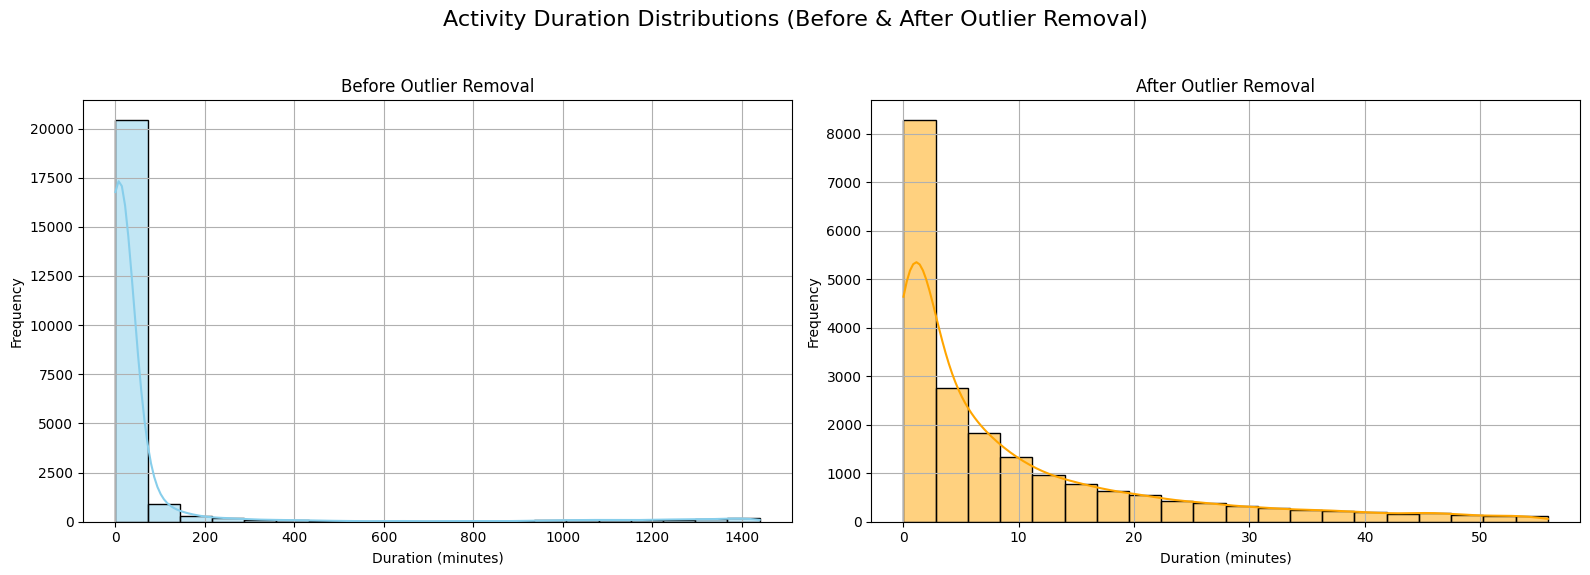

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Activity Duration Distributions (Before & After Outlier Removal)", fontsize=16)

sns.histplot(activities_before['duration_minutes'], bins=20, color='skyblue', ax=axes[0], kde=True)
axes[0].set_title('Before Outlier Removal')
axes[0].set_xlabel('Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

sns.histplot(activities['duration_minutes'], bins=20, color='orange', ax=axes[1], kde=True)
axes[1].set_title('After Outlier Removal')
axes[1].set_xlabel('Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Dictionaries for relevant courses

In [7]:
# Create mapping course_id -> course name/short name

class SmartMap(dict):
    def __missing__(self, key):
        return f"Unknown({key})"
    
course_map = SmartMap({
    42 : 'Langzeitgymnasium maths',
    3865 : 'Kurzzeitgymnasium maths',
    5447 : 'Langzeitgymnasium essay',
    2115 : 'Langzeitgymnasium text comprehension',
    5009 : 'Kurzzeitgymnasium text comprehension',
    3301 : 'Kurzzeitgymnasium essay',
    1696 : 'Student site introduction',
    8117 : 'Teacher site introduction'
})

course_map_short = SmartMap({
    42 : 'LZG_M',
    3865 : 'KZG_M',
    5447 : 'LZG_E',
    2115 : 'LZG_TC',
    5009 : 'KZG_TC',
    3301 : 'KZG_E',
    1696 : 'SSI',
    8117 : 'TSI'
})

In [8]:
activities_copy = activities.copy(deep=True)

# Cook some dataframes for the clustering

## Inputs

### Brewing of zduration_sum

#### For each user, course, and activity type combination, we calculate the z-score relative to the distribution of all users for the same course and activity type.

In [9]:
def compute_zduration(df_in, user_agg='sum'):
    """
    Compute z-score normalized duration for each user per (course_id, activity_type) pair.

    Parameters:
        df_in: pd.DataFrame with columns: user_id, course_id, activity_type, duration
        user_agg: str, 'sum' or 'mean'

    Returns:
        pd.DataFrame with: user_id, course_id, activity_type, duration, mean_duration, std_duration, zscore_duration
    """

    # 0. Copy as to not modify the input dataframe
    df = df_in.copy(deep=True)

    # 1. Aggregate per user per (course_id, activity_type)
    user_activity = (
        df.groupby(['user_id', 'course_id', 'activity_type'], as_index=False)
          .agg({'duration': user_agg})
    )

    # 2. Compute mean and std per (course_id, activity_type)
    stats = (
        user_activity.groupby(['course_id', 'activity_type'])['duration']
        .agg(['mean', 'std']).reset_index()
        .rename(columns={'mean': 'mean_duration', 'std': 'std_duration'})
    )

    # 3. Merge
    merged = user_activity.merge(stats, on=['course_id', 'activity_type'], how='left')

    # 4. Z-score
    merged['zscore_duration'] = (merged['duration'] - merged['mean_duration']) / merged['std_duration']

    return merged[['user_id', 'course_id', 'activity_type', 'duration', 'mean_duration', 'std_duration', 'zscore_duration']]


In [10]:
zduration_sum = compute_zduration(activities, 'sum')

In [11]:
zduration_sum.head()

,user_id,course_id,activity_type,duration,mean_duration,std_duration,zscore_duration
0,1,3301,quiz,0 days 00:04:59,0 days 00:06:16.612121212,0 days 00:05:57.196666262,-0.217281
1,1,3301,topic,0 days 00:00:11,0 days 01:01:16.201716738,0 days 00:56:35.367471301,-1.079471
2,1,3865,quiz,0 days 00:19:26,0 days 02:48:46.236607142,0 days 02:33:54.677760883,-0.970281
3,1,3865,topic,0 days 00:56:11,0 days 01:48:34.604095563,0 days 01:46:45.686579520,-0.490752
4,1,5009,topic,0 days 03:05:13,0 days 01:26:28.571428571,0 days 01:28:26.502501462,1.116447


### Brewing of gap_days

In [12]:
user_daily_activity = activities.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Ceate a csv of user_ids, gap_days where gap_days is a list of the gaps (ignore nans) in increasing order. Use copies of the dataframes
df = user_daily_activity.copy(deep=True)[['user_id', 'gap_days']]
# Remove the first gap_days (nan) for each user
df.dropna(subset=['gap_days'], inplace=True)
# Group by user_id and aggregate the gap_days into a list
df = df.groupby('user_id')['gap_days'].apply(lambda x: list(x)).reset_index()
# Sort the gap_days list for each user
df['gap_days'] = df['gap_days'].apply(lambda x: sorted(x))

gap_days = df.copy(deep=True)

# Save to csv
gap_days.to_csv(f'{DATA_DIR}/user_gap_days.csv', index=False)

In [13]:
gap_days.head()

,user_id,gap_days
0,1,"[1.0, 1.0, 2.0, 2.0, 2.0, 4.0, 4.0, 7.0, 19.0,..."
1,4,"[2.0, 6.0, 7.0, 8.0, 13.0, 51.0]"
2,6,"[2.0, 2.0, 6.0, 6.0, 8.0, 14.0, 20.0, 44.0]"
3,7,"[1.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, ..."
4,9,"[2.0, 7.0, 8.0, 12.0, 18.0, 24.0, 25.0]"


### Brewing of user_chains

#### Create transition matrices for each user

In [14]:
transitions = activities.copy()

transitions.sort_values(by=['user_id', 'activity_started'], ascending=True, inplace=True)

# Build activity_state = (activity_type, course_id) and log durations where possible
transitions['activity_state'] = transitions['activity_type'] + '_' + transitions['course_id'].map(course_map_short).fillna('Unknown')


# Index states numerically
state_to_idx = {s: i for i, s in enumerate(transitions['activity_state'].unique())}
transitions['state_idx'] = transitions['activity_state'].map(state_to_idx)

# Log subsequent states into a separate column
transitions['next_state_idx'] = transitions.groupby('user_id')['state_idx'].shift(-1)
transitions = transitions.dropna(subset=['next_state_idx']).copy()
transitions['next_state_idx'] = transitions['next_state_idx'].astype(int)



all_states = transitions['activity_state'].unique().tolist()
n_states = len(all_states)

final_transitions = transitions[['user_id', 'activity_state', 'state_idx', 'next_state_idx']]
final_transitions

,user_id,activity_state,state_idx,next_state_idx
36137,1,quiz_KZG_E,0,1
45192,1,topic_KZG_TC,1,1
45206,1,topic_KZG_TC,1,1
46437,1,topic_KZG_TC,1,1
47334,1,topic_KZG_TC,1,1
...,...,...,...,...
48050,4095,topic_KZG_M,3,3
48051,4095,topic_KZG_M,3,4
48266,4095,quiz_KZG_M,4,4
48272,4095,quiz_KZG_M,4,4


In [15]:
# Helper dictionary
idx_to_state = {i: name for name, i in state_to_idx.items()}

In [16]:
import pandas as pd

# total number of possible states
n_states = max(
    final_transitions['state_idx'].max(),
    final_transitions['next_state_idx'].max()
) + 1

def make_pruned_absorbing_P(df):
    # 1) build full count‐matrix
    counts = pd.crosstab(df['state_idx'], df['next_state_idx'])
    counts = counts.reindex(
        index=range(n_states),
        columns=range(n_states),
        fill_value=0
    )

    # 2) pick any state that appears as from‐state OR to‐state
    used = (counts.sum(axis=1) > 0) | (counts.sum(axis=0) > 0)
    used_states = counts.index[used]     # these are the original idxs we keep

    # 3) prune to only those
    pruned = counts.loc[used_states, used_states].copy()

    # 4) make any zero‐row into an absorbing self‐loop
    zero_rows = pruned.sum(axis=1) == 0
    for s in zero_rows[zero_rows].index:
        pruned.at[s, s] = 1

    # 5) normalize each row
    P = pruned.div(pruned.sum(axis=1), axis=0)
    return P

# apply per user
user_pruned_matrices = {
    uid: make_pruned_absorbing_P(g)
    for uid, g in final_transitions.groupby('user_id')
}

# now for that user with only 10→10×3 and 10→11×1:
P_example = user_pruned_matrices[18]
print(P_example)


state_idx    10    11
state_idx            
10         0.75  0.25
11         0.00  1.00


#### Create a Markov Chain for each user

In [17]:
user_chains = {}

for uid in user_pruned_matrices:
    pruned_matrix = user_pruned_matrices[uid]
    if pruned_matrix.shape[0]>1:
        user_chains[uid] = MarkovChain(pruned_matrix, [idx_to_state[i] for i in pruned_matrix.index.tolist()])
    else:
        user_chains.pop(uid, None)

In [18]:
print(MarkovChain(user_pruned_matrices[18], [idx_to_state[i] for i in user_pruned_matrices[18].index.tolist()]))


DISCRETE-TIME MARKOV CHAIN
 SIZE:           2
 RANK:           2
 CLASSES:        2
  > RECURRENT:   1
  > TRANSIENT:   1
 ERGODIC:        NO
  > APERIODIC:   YES
  > IRREDUCIBLE: NO
 ABSORBING:      YES
 MONOTONE:       YES
 REGULAR:        NO
 REVERSIBLE:     YES
 SYMMETRIC:      NO



In [19]:
state_to_idx

{'quiz_KZG_E': 0,
 'topic_KZG_TC': 1,
 'topic_KZG_E': 2,
 'topic_KZG_M': 3,
 'quiz_KZG_M': 4,
 'topic_LZG_M': 5,
 'quiz_LZG_M': 6,
 'lesson_LZG_TC': 7,
 'topic_LZG_TC': 8,
 'lesson_LZG_E': 9,
 'topic_LZG_E': 10,
 'quiz_LZG_E': 11,
 'lesson_KZG_M': 12,
 'lesson_KZG_E': 13,
 'lesson_LZG_M': 14,
 'lesson_KZG_TC': 15}

In [20]:
final_transitions.dtypes

user_id            int64
activity_state    object
state_idx          int64
next_state_idx     int64
dtype: object

## Outputs

### Create zscores per course for each user, course pair, keep percentages for visualizations

In [21]:
df = all_scores.copy()
df["zscore"] = df.groupby("course")["percentage"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
zscores = df.rename(columns={'course': 'course_id'})

zscores.describe()

,user_id,course_id,percentage,zscore
count,6432.000000,6432.000000,6432.000000,6.432000e+03
mean,2420.168999,2894.153141,56.098510,-1.115747e-16
std,1698.985735,2011.163854,29.366960,1.000078e+00
min,1.000000,42.000000,0.000000,-5.423334e+00
25%,332.000000,42.000000,36.099727,-6.343278e-01
50%,3503.000000,3865.000000,62.500000,2.908645e-02
75%,3932.000000,3865.000000,78.000000,7.789549e-01
max,4095.000000,5447.000000,100.000000,3.370601e+00


# Some visualizations - for pallette cleansing and to orient before clustering

## Some stats of durations on per course, activity type basis

In [22]:
course_median_duration = activities.groupby(['course_id', 'activity_type'])['duration'].median().reset_index()
print(course_median_duration)

    course_id activity_type               duration
0          42        lesson 0 days 00:11:48.500000
1          42          quiz 0 days 00:05:07.500000
2          42         topic        0 days 00:02:02
3        2115        lesson        0 days 00:03:42
4        2115         topic 0 days 00:01:54.500000
5        3301        lesson        0 days 00:18:01
6        3301          quiz 0 days 00:03:50.500000
7        3301         topic        0 days 00:06:39
8        3865        lesson        0 days 00:07:58
9        3865          quiz        0 days 00:10:47
10       3865         topic        0 days 00:04:05
11       5009        lesson        0 days 00:14:07
12       5009         topic        0 days 00:03:45
13       5447        lesson        0 days 00:11:05
14       5447          quiz 0 days 00:02:56.500000
15       5447         topic        0 days 00:05:05


In [23]:
# GPT-generated visualization

def plot_course_durations(df_median, course_map_short):
    # Prepare the data
    df_median = df_median.copy()
    df_median['duration_sec'] = df_median['duration'].dt.total_seconds()
    
    total_durations = df_median.groupby('course_id')['duration_sec'].sum()
    max_total_duration = total_durations.max()

    # Color map for activities
    activity_types = sorted(df_median['activity_type'].unique())
    cmap = plt.get_cmap('Set2')
    colors = cmap(np.linspace(0, 1, len(activity_types)))
    color_map = dict(zip(activity_types, colors))

    # Plot settings
    courses = total_durations.sort_values(ascending=False).index
    n_courses = len(courses)
    n_cols = 3
    n_rows = int(np.ceil(n_courses / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    for idx, course_id in enumerate(courses):
        ax = axes[idx]
        course_data = df_median[df_median['course_id'] == course_id]
        durations = course_data['duration_sec'].values
        labels = course_data['activity_type'].values

        total_duration = durations.sum()
        course_fraction = total_duration / max_total_duration
        max_angle = 360 * course_fraction  # Total filled angle for this course

        # Compute sizes in angles instead of fractions of 1
        sizes = durations / total_duration * max_angle

        start_angle = 90
        for label, size in zip(labels, sizes):
            ax.pie(
                [size, 360 - size], 
                colors=[color_map[label], (0, 0, 0, 0)],  # Transparent for remaining part
                startangle=start_angle, 
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )
            start_angle -= size  # Update start angle for next segment

        # Draw the remaining transparent gap (optional light gray)
        if course_fraction < 1:
            ax.pie(
                [360 * (1 - course_fraction), 360 * course_fraction],
                colors=['#f0f0f0', (0, 0, 0, 0)],
                startangle=90 - max_angle,
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )

        # Add center text
        course_name = course_map_short.get(course_id, course_id)
        total_hours = int(total_duration // 3600)
        total_minutes = int((total_duration % 3600) // 60)
        ax.text(0, 0.1, course_name, ha='center', va='center', fontsize=12, weight='bold')
        ax.text(0, -0.1, f"{total_hours}h {total_minutes}m", ha='center', va='center', fontsize=10)
        
        ax.set_aspect('equal')
        ax.axis('off')
    
    # Remove unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    # Add Legend
    legend_patches = [mpatches.Patch(color=color_map[act], label=act) for act in activity_types]
    fig.legend(
        handles=legend_patches, 
        loc='upper right', 
        fontsize=10, 
        title='Activity Types'
    )
    plt.title("Course Durations", fontsize=16, loc='center')

    
    plt.tight_layout()
    plt.show()


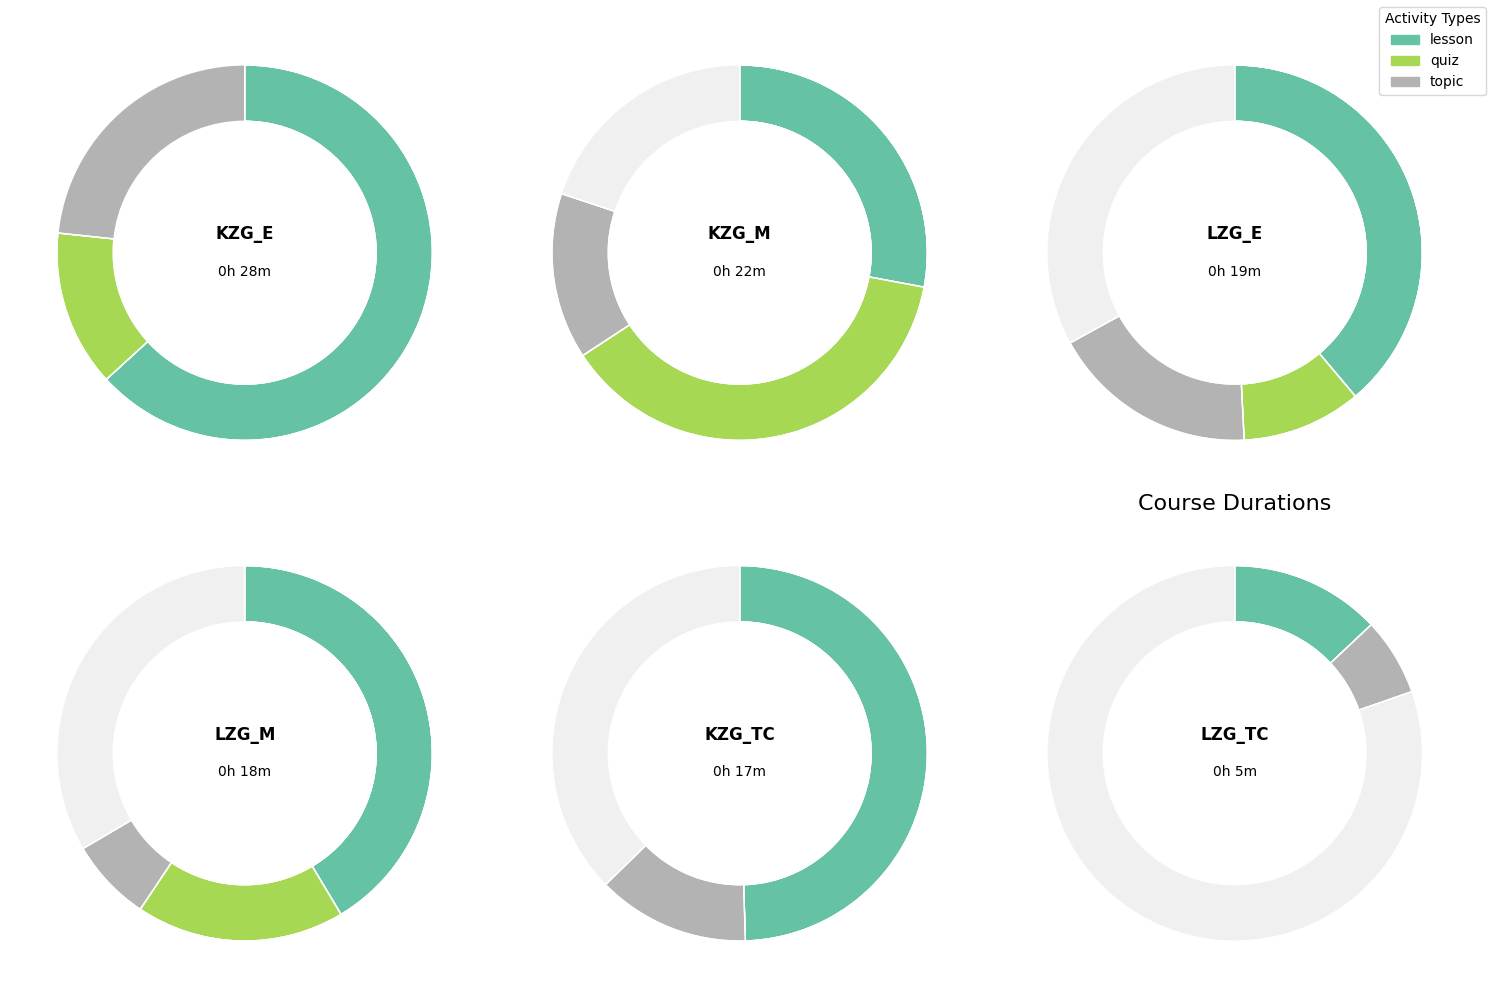

In [24]:
plot_course_durations(course_median_duration, course_map_short)

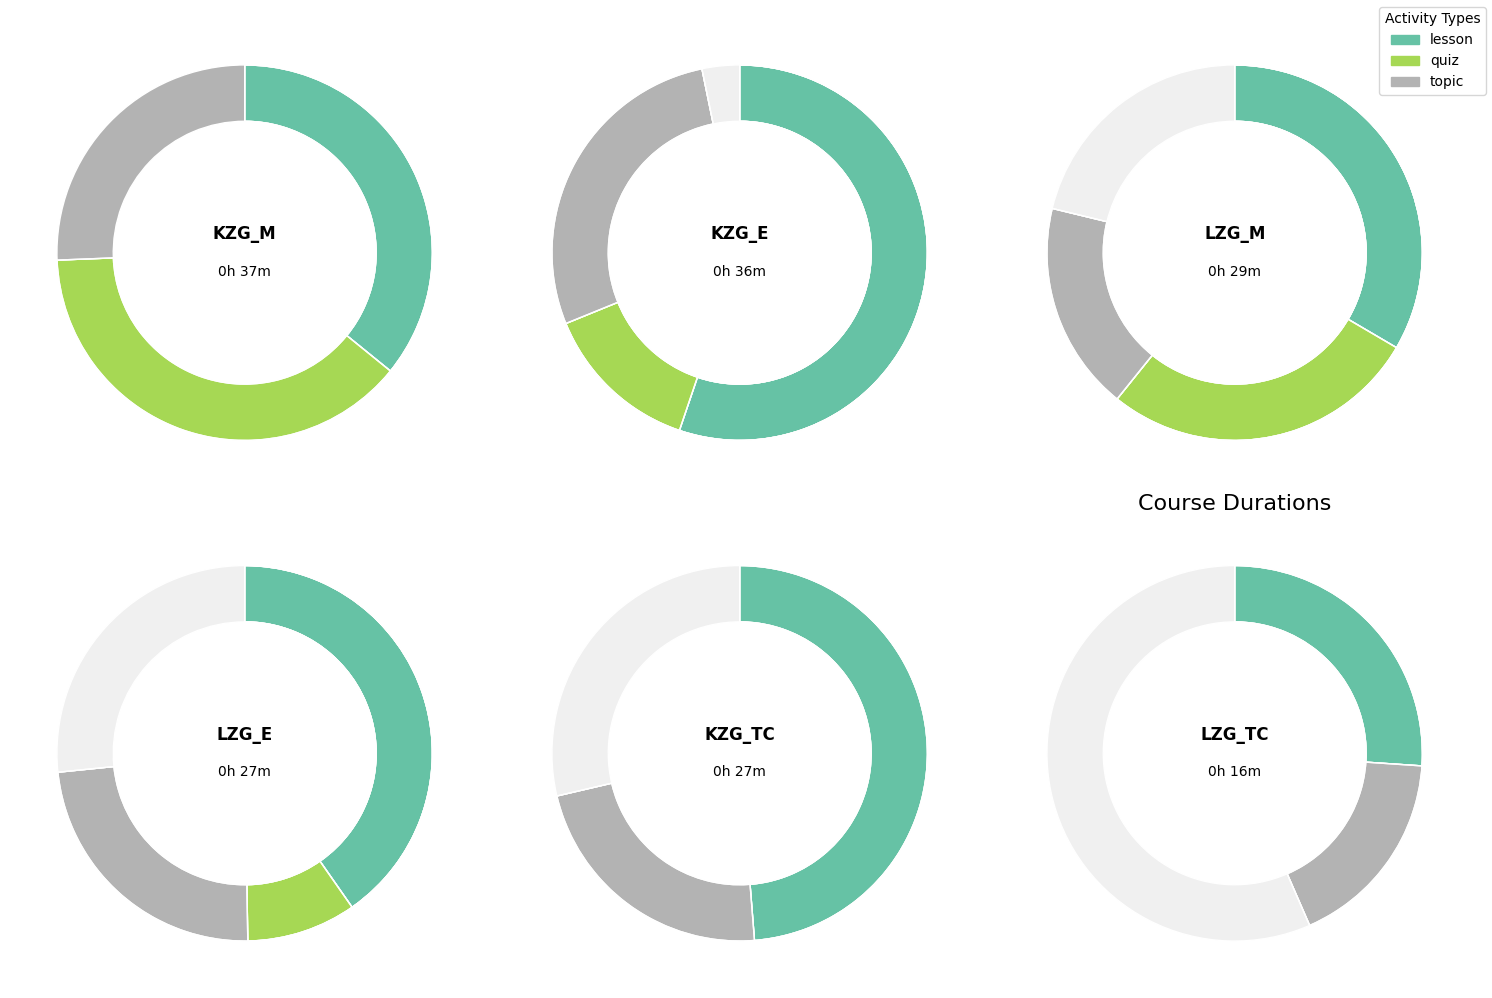

In [25]:
plot_course_durations(activities.groupby(['course_id', 'activity_type'])['duration'].mean().reset_index(), course_map_short)

### Some sanity-check prints

In [26]:
course_median_duration.activity_type.unique()

array(['lesson', 'quiz', 'topic'], dtype=object)

In [27]:
activities.columns

Index(['user_id', 'course_id', 'activity_type', 'activity_started',
       'activity_completed', 'duration', 'duration_minutes'],
      dtype='object')

In [28]:
activities.dtypes

user_id                         int64
course_id                       int64
activity_type                  object
activity_started       datetime64[ns]
activity_completed     datetime64[ns]
duration              timedelta64[ns]
duration_minutes              float64
dtype: object

In [29]:
course_median_duration.columns

Index(['course_id', 'activity_type', 'duration'], dtype='object')

In [30]:
course_median_duration.dtypes

course_id                  int64
activity_type             object
duration         timedelta64[ns]
dtype: object

In [31]:
activities.head()

,user_id,course_id,activity_type,activity_started,activity_completed,duration,duration_minutes
19,2533,42,topic,2023-04-07 16:42:38,2023-04-07 16:43:58,0 days 00:01:20,1.333333
20,2533,42,topic,2023-04-07 16:43:59,2023-04-07 16:46:13,0 days 00:02:14,2.233333
21,2533,42,topic,2023-04-07 16:46:14,2023-04-07 16:46:27,0 days 00:00:13,0.216667
22,2533,42,topic,2023-04-07 16:46:28,2023-04-07 16:48:11,0 days 00:01:43,1.716667
23,2533,42,topic,2023-04-07 16:48:12,2023-04-07 16:54:48,0 days 00:06:36,6.600000


## GUI to explore users' markov chains

#### You can observe what each user's working on: user 22 for example is only doing long-time gymnasium essays

In [32]:
import ipywidgets as widgets
import networkx as nx
import plotly.graph_objs as go
from IPython.display import display
import numpy as np

def plot_user_markov_with_edge_labels(user_id):
    mc = user_chains[user_id]
    matrix = np.array(mc.p)
    states = mc.states

    # Identify non-trivial states
    non_trivial_states = set()
    for i, state in enumerate(states):
        row = matrix[i]
        col = matrix[:, i]
        if not (np.isclose(row[i], 1.0) and np.isclose(row.sum(), 1.0) and np.isclose(col.sum(), 1.0)):
            non_trivial_states.add(state)

    # Build filtered graph
    G = nx.DiGraph()
    for i, from_state in enumerate(states):
        if from_state not in non_trivial_states:
            continue
        for j, to_state in enumerate(states):
            if to_state in non_trivial_states and matrix[i, j] > 0:
                G.add_edge(from_state, to_state, weight=round(matrix[i, j], 2))

    if len(G.nodes) == 0:
        print(f"No significant transitions to visualize for User {user_id}.")
        return

    pos = nx.spring_layout(G, seed=42)  # Better separation

    edge_traces = []
    edge_annotations = []

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2]['weight']

        # Compute curvature offset
        offset = 0.1 if G.has_edge(edge[1], edge[0]) and edge[0] != edge[1] else 0
        ctrl_x = (x0 + x1) / 2 + offset * (y1 - y0)
        ctrl_y = (y0 + y1) / 2 + offset * (x0 - x1)

        curve_x = [x0, ctrl_x, x1]
        curve_y = [y0, ctrl_y, y1]

        edge_traces.append(go.Scatter(
            x=curve_x, y=curve_y,
            line=dict(width=2, color='gray', shape='spline'),
            mode='lines',
            hoverinfo='none'
        ))

        # Label near the curve's control point
        edge_annotations.append(dict(
            x=ctrl_x, y=ctrl_y,
            xref='x', yref='y',
            text=f"{weight}",
            showarrow=False,
            font=dict(color='black', size=14),
            bgcolor='rgba(255, 255, 255, 0.7)',
            bordercolor='black',
            borderwidth=1,
            borderpad=2,
            align='center',
            opacity=0.9
        ))

        # Arrow at the end
        edge_annotations.append(dict(
            ax=ctrl_x, ay=ctrl_y,
            x=x1, y=y1,
            axref='x', ayref='y',
            xref='x', yref='y',
            showarrow=True,
            arrowhead=3,
            arrowsize=2,
            arrowwidth=2,
            arrowcolor='gray',
            opacity=0.8
        ))

    # Node Trace
    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        text=list(G.nodes()),
        mode='markers+text',
        textposition='middle center',
        marker=dict(size=60, color='lightblue', line=dict(width=3, color='darkblue'))
    )

    fig = go.Figure(data=edge_traces + [node_trace],
                    layout=go.Layout(
                        title=f"User {user_id} Markov Model (Non-Trivial States)",
                        title_x=0.5,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(t=50, l=25, r=25, b=25),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        annotations=edge_annotations,
                        width=800,
                        height=600
                    ))
    fig.show()

# Interactive widget
user_selector = widgets.Dropdown(
    options=sorted(user_chains.keys()),
    description='User ID:',
    continuous_update=False
)

out = widgets.Output()

def on_user_change(change):
    with out:
        out.clear_output(wait=True)
        plot_user_markov_with_edge_labels(change['new'])

user_selector.observe(on_user_change, names='value')

display(user_selector, out)

# Auto-trigger initial plot
user_selector.value = sorted(user_chains.keys())[0]

Dropdown(description='User ID:', options=(1, 4, 6, 7, 9, 10, 11, 16, 17, 18, 19, 20, 22, 23, 26, 28, 30, 32, 3…

Output()

#### Limit to only intersection of users

In [33]:
zduration_users = set(zduration_sum['user_id'])
gap_days_users = set(gap_days['user_id'])
user_chains_users = set(user_chains.keys())

# Find the intersection
common_users = zduration_users & gap_days_users & user_chains_users

# Filter each dataframe/dict to only the common users
zduration_sum = zduration_sum[zduration_sum['user_id'].isin(common_users)]
gap_days = gap_days[gap_days['user_id'].isin(common_users)]
user_chains = {k: v for k, v in user_chains.items() if k in common_users}

common_users = sorted(common_users)

# Print the number of users in the intersection
print(f'Number of users in all three: {len(common_users)}')

Number of users in all three: 589


In [34]:
# Recap dataframes we will be using after processing

# Clustering inputs
zduration_sum
gap_days
user_chains

# Validation via
zscores


,user_id,course_id,percentage,zscore
0,2533,42,14.290000,-1.298893
1,2533,42,55.560000,-0.045130
2,2533,42,10.000000,-1.429221
3,2533,42,30.000000,-0.821631
4,2533,3865,0.000000,-1.733729
...,...,...,...,...
6427,3842,5447,77.647059,0.470948
6428,3596,5447,61.176471,-0.388711
6429,3596,5447,64.705882,-0.204498
6430,3596,5447,63.529412,-0.265903


In [35]:
import numpy as np
import pandas as pd
import networkx as nx
from itertools import combinations
from scipy.spatial.distance import jensenshannon



def compute_js_and_penalty(c1, c2, alpha=0.5, pen_multiplier=1):
    """Returns α·JS + (1–α)·penalty for the common‐states subchain (or None)."""
    common = set(c1.states) & set(c2.states)
    if len(common) < 2:
        return None

    # Extract submatrices
    idx1 = [c1.states.index(s) for s in common]
    idx2 = [c2.states.index(s) for s in common]
    P = c1.p[np.ix_(idx1, idx1)]
    Q = c2.p[np.ix_(idx2, idx2)]

    # JS divergence (row‐wise average)
    js_vals = []
    for row_p, row_q in zip(P, Q):
        if row_p.sum() > 0 and row_q.sum() > 0:
            # account for possible underflow
            raw = jensenshannon(row_p, row_q, base=2)
            js_vals.append(max(raw, 0.0))
    js = float(np.nanmean(js_vals)) if js_vals else 1.0

    # penalty = fraction of non-overlap
    total_states = set(c1.states) | set(c2.states)
    pen = 1 - (len(common) / len(total_states))
    pen = pen*pen_multiplier

    return alpha * js + (1 - alpha) * pen

# def compute_js_and_penalty(c1, c2, alpha=0.5):
#     common = set(c1.states) & set(c2.states)
#     if len(common) < 2:
#         # Too few states to do a meaningful JS; either skip or set js=0
#         return None
#     else:
#         # Get sub‐matrices
#         idx1 = [c1.states.index(s) for s in common]
#         idx2 = [c2.states.index(s) for s in common]
#         P = c1.p[np.ix_(idx1, idx1)]
#         Q = c2.p[np.ix_(idx2, idx2)]

#         js_vals = []
#         for p_row, q_row in zip(P, Q):
#             sp, sq = p_row.sum(), q_row.sum()
#             if sp > 0 and sq > 0:
#                 # normalize
#                 p_norm = p_row / sp
#                 q_norm = q_row / sq
#                 # account for possible underflow
#                 raw = jensenshannon(p_norm, q_norm, base=2)
#                 js_vals.append(max(raw, 0.0))
#         # only aggregate if we got something
#         js = float(np.mean(js_vals)) if js_vals else 1.0

#     # structural penalty as before
#     total = set(c1.states) | set(c2.states)
#     pen = 1 - (len(common) / len(total)) if total else 1.0

#     return alpha * js + (1 - alpha) * pen

def build_distance_matrix(user_chains, alpha=0.5, pen_multiplier=1):
    users = list(user_chains.keys())
    n = len(users)
    INF = float('inf')

    # 1) Initialize the “direct” distance lookup
    direct = { (u,v): (0.0 if u==v else INF)
               for u in users for v in users }

    # 2) Fill in distances for pairs with common states
    for u1, u2 in combinations(users, 2):
        dist = compute_js_and_penalty(user_chains[u1],
                                      user_chains[u2],
                                      alpha=alpha,
                                      pen_multiplier=pen_multiplier)
        if dist is not None:
            direct[(u1,u2)] = direct[(u2,u1)] = dist

    # 3) Build a graph whose edges are exactly those “direct” distances
    G = nx.Graph()
    G.add_nodes_from(users)
    for (u,v), w in direct.items():
        if u != v and w < INF:
            G.add_edge(u, v, weight=w)

    # 4) Compute all‐pairs shortest paths on G
    sp_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

    # 5) Assemble full DataFrame
    D = pd.DataFrame(INF, index=users, columns=users)
    for u in users:
        for v, d in sp_lengths[u].items():
            D.at[u, v] = d

    # 6) Count connected components (for reporting)
    n_components = nx.number_connected_components(G)

    return D, n_components

# -----------------------
# Example usage:

# Suppose you have:
#   user_chains = {
#       'alice': some_pydtmc.MarkovChain,
#       'bob':   some_pydtmc.MarkovChain,
#       ...
#   }

dist_matrix, components = build_distance_matrix(user_chains, alpha=0.2,pen_multiplier=1)
print("Distance matrix:\n", dist_matrix)
print("Connected components:", components)


/opt/homebrew/Caskroom/miniconda/base/envs/gogymi/lib/python3.12/site-packages/scipy/spatial/distance.py:1391: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/var/folders/tb/xz8bmvcs5mjgtg8nqczpcrcc0000gn/T/ipykernel_6391/1158574172.py:28: RuntimeWarning: Mean of empty slice
  js = float(np.nanmean(js_vals)) if js_vals else 1.0


Distance matrix:
           1         4         6         7         9         10        11    \
1     0.000000  0.377822  0.098242  0.144507  0.130248  0.578242  0.980537   
4     0.377822  0.000000  0.443728  0.387207  0.400583  0.393505  1.050213   
6     0.098242  0.443728  0.000000  0.143825  0.119494  0.480000  1.062232   
7     0.144507  0.387207  0.143825  0.000000  0.096920  0.581855  1.045450   
9     0.130248  0.400583  0.119494  0.096920  0.000000  0.521460  1.028449   
...        ...       ...       ...       ...       ...       ...       ...   
4087  0.262142  0.538361  0.219496  0.239450  0.199345  0.699496  1.080394   
4089  1.105360  1.221129  1.111289  1.079715  1.064103  1.283431  0.455695   
4090  1.147457  1.263226  1.153386  1.121812  1.106200  1.391585  0.635575   
4092  0.469443  0.585211  0.475372  0.443798  0.428186  0.722222  0.683204   
4095  0.235378  0.480000  0.219337  0.278719  0.239361  0.684851  1.073714   

          16        17        19    ...      

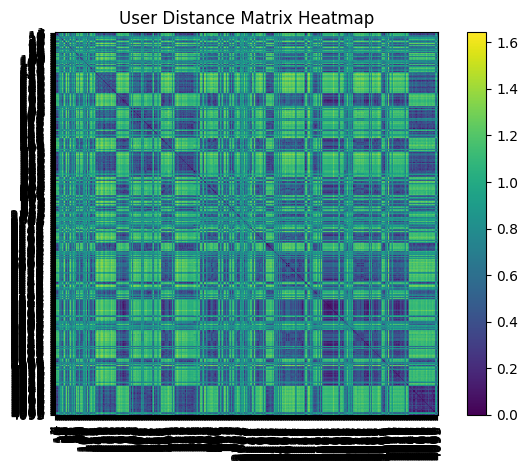

In [36]:
import matplotlib.pyplot as plt

# Assume `dist_matrix` is a pandas DataFrame of shape (n_users, n_users)
# with user IDs as both index and columns.

fig, ax = plt.subplots()
im = ax.imshow(dist_matrix.values)

# Label axes with user IDs
ax.set_xticks(range(len(dist_matrix.columns)))
ax.set_xticklabels(dist_matrix.columns, rotation=90)
ax.set_yticks(range(len(dist_matrix.index)))
ax.set_yticklabels(dist_matrix.index)

ax.set_title('User Distance Matrix Heatmap')

# Add a colorbar to interpret distances
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


In [37]:
activities.head()

,user_id,course_id,activity_type,activity_started,activity_completed,duration,duration_minutes
19,2533,42,topic,2023-04-07 16:42:38,2023-04-07 16:43:58,0 days 00:01:20,1.333333
20,2533,42,topic,2023-04-07 16:43:59,2023-04-07 16:46:13,0 days 00:02:14,2.233333
21,2533,42,topic,2023-04-07 16:46:14,2023-04-07 16:46:27,0 days 00:00:13,0.216667
22,2533,42,topic,2023-04-07 16:46:28,2023-04-07 16:48:11,0 days 00:01:43,1.716667
23,2533,42,topic,2023-04-07 16:48:12,2023-04-07 16:54:48,0 days 00:06:36,6.600000


In [38]:
zduration_sum.head()

,user_id,course_id,activity_type,duration,mean_duration,std_duration,zscore_duration
0,1,3301,quiz,0 days 00:04:59,0 days 00:06:16.612121212,0 days 00:05:57.196666262,-0.217281
1,1,3301,topic,0 days 00:00:11,0 days 01:01:16.201716738,0 days 00:56:35.367471301,-1.079471
2,1,3865,quiz,0 days 00:19:26,0 days 02:48:46.236607142,0 days 02:33:54.677760883,-0.970281
3,1,3865,topic,0 days 00:56:11,0 days 01:48:34.604095563,0 days 01:46:45.686579520,-0.490752
4,1,5009,topic,0 days 03:05:13,0 days 01:26:28.571428571,0 days 01:28:26.502501462,1.116447


In [39]:
# 4. zduration_sum Graph-based Distance
n_users = len(common_users)

B = nx.Graph()
B.add_nodes_from(common_users, bipartite='user')
activities_list = list(
    set(tuple(x) for x in zduration_sum[['course_id', 'activity_type']].to_numpy())
)
print(activities_list)
B.add_nodes_from(activities_list, bipartite='activity')

for row in zduration_sum.itertuples(index=False):
    B.add_edge(row.user_id, (row.course_id, row.activity_type), weight=row.zscore_duration)

graph_matrix = np.zeros((n_users, n_users))
for i in range(n_users):
    for j in range(i + 1, n_users):
        u1, u2 = common_users[i], common_users[j]
        u1_acts = set(B.neighbors(u1))
        u2_acts = set(B.neighbors(u2))
        common_acts = u1_acts & u2_acts
        if common_acts:
            z1 = [B.edges[u1, act]['weight'] for act in common_acts]
            z2 = [B.edges[u2, act]['weight'] for act in common_acts]
            dist = np.linalg.norm(np.array(z1) - np.array(z2))
        else:
            try:
                path = nx.shortest_path(B, u1, u2)
                edge_weights = []
                for k in range(0, len(path) - 2, 2):
                    z1 = B.edges[path[k], path[k+1]]['weight']
                    z2 = B.edges[path[k+2], path[k+1]]['weight']
                    edge_weights.append(abs(z1 - z2))
                dist = sum(edge_weights)
            except nx.NetworkXNoPath:
                dist = np.nan
        graph_matrix[i, j] = graph_matrix[j, i] = dist

max_g = np.nanmax(graph_matrix[~np.isnan(graph_matrix)])
graph_matrix = np.nan_to_num(graph_matrix, nan=max_g * 1.1)

[(42, 'quiz'), (3865, 'topic'), (3301, 'topic'), (5009, 'lesson'), (5447, 'lesson'), (42, 'lesson'), (3865, 'lesson'), (42, 'topic'), (3301, 'lesson'), (5447, 'quiz'), (2115, 'topic'), (3865, 'quiz'), (3301, 'quiz'), (2115, 'lesson'), (5447, 'topic'), (5009, 'topic')]


In [40]:
from tslearn.metrics import dtw

# 2. gap_days DTW Distance Matrix
gap_days_map = gap_days.set_index('user_id')['gap_days'].to_dict()
gap_days_seqs = [gap_days_map[u] for u in common_users]
dtw_matrix = np.zeros((n_users, n_users))
for i in range(n_users):
    for j in range(i + 1, n_users):
        d = dtw(gap_days_seqs[i], gap_days_seqs[j])
        dtw_matrix[i, j] = dtw_matrix[j, i] = d

In [41]:
# 5. Normalize and Combine
def normalize_matrix(m):
    flat = m[np.triu_indices_from(m, 1)]
    m_norm = np.zeros_like(m)
    if flat.max() > flat.min():
        m_norm = (m - flat.min()) / (flat.max() - flat.min())
    return m_norm

dtw_norm = normalize_matrix(dtw_matrix)
graph_norm = normalize_matrix(graph_matrix)
combined_matrix = (dtw_norm + 2*dist_matrix + graph_norm) / 3.0


In [42]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.cluster import SpectralClustering
# from sklearn.manifold import spectral_embedding
# from sklearn.metrics import silhouette_score
# from scipy.sparse.csgraph import laplacian
# from scipy.linalg import eigh

# # If combined_matrix is a DataFrame, turn it into a NumPy array:
# dist = combined_matrix.values if hasattr(combined_matrix, "values") else combined_matrix

# # ---- 1. compute local scales from your distance matrix ----
# n = dist.shape[0]
# k_local = min(7, n-1)
# sorted_d = np.sort(dist, axis=1)
# sigma = sorted_d[:, k_local]
# sigma_i_j = np.outer(sigma, sigma)
# affinity = np.exp(- dist**2 / sigma_i_j)

# # ---- 2. compute normalized Laplacian eigengap ----
# # Convert affinity to array as well, just in case:
# A = affinity if isinstance(affinity, np.ndarray) else affinity.values
# L = laplacian(A, normed=True)
# eigvals, _ = eigh(L)
# # compute gaps and pick best k up to say 10
# max_k = min(10, n-1)
# gaps = eigvals[1:max_k+1] - eigvals[:max_k]
# best_n = np.argmax(gaps) + 1

# print(f"Selected number of clusters by eigengap: {best_n}")

# # ---- 3. (optional) sanity check with silhouette ----
# labels = SpectralClustering(
#     n_clusters=best_n,
#     affinity='precomputed',
#     random_state=42
# ).fit_predict(affinity)

# X_lap = spectral_embedding(
#     adjacency=A,
#     n_components=best_n,
#     norm_laplacian=True
# )
# sil_emb = silhouette_score(X_lap, labels, metric='euclidean')
# print(f"Silhouette (embedding space): {sil_emb:.3f}")

# # (Optional) if you still want the raw-distance silhouette for comparison:
# sil_raw = silhouette_score(dist, labels, metric='precomputed')
# print(f"Silhouette (raw distances):   {sil_raw:.3f}")

# # ---- 4. visualize the gap if you like ----
# plt.figure(figsize=(6,4))
# plt.plot(range(1, max_k+1), gaps, marker='o')
# plt.axvline(best_n, color='red', linestyle='--', label=f'pick k={best_n}')
# plt.xlabel('i (candidate #clusters)')
# plt.ylabel('λ_{i+1} − λ_i (eigengap)')
# plt.legend()
# plt.title('Eigengap Heuristic for Self-Tuning Spectral Clustering')
# plt.show()

# # ---- 5. assemble your DataFrame ----
# cluster_df = pd.DataFrame({
#     'user_id': common_users,
#     'cluster': labels
# })
# display(cluster_df)


In [43]:
# best_labels = labels

Best number of clusters: 2 (silhouette score: 0.560)


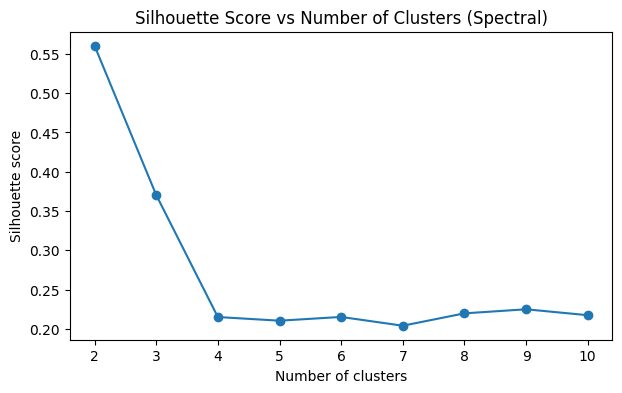

,user_id,cluster
0,1,0
1,4,0
2,6,0
3,7,0
4,9,0
...,...,...
584,4087,0
585,4089,1
586,4090,1
587,4092,0


In [44]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Convert distance matrix to similarity (kernel trick: exp(-distance^2 / (2*sigma^2)))
sigma = np.median(combined_matrix)
similarity_matrix = np.exp(-combined_matrix ** 2 / (2.0 * sigma ** 2))

range_n_clusters = range(2, min(11, len(common_users)))
sil_scores = []
best_score = -1
best_n = None
best_labels = None

for n_clusters in range_n_clusters:
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = clustering.fit_predict(similarity_matrix)
    # Silhouette expects a distance matrix, so use the original distance
    score = silhouette_score(combined_matrix, labels, metric='precomputed')
    sil_scores.append(score)
    if score > best_score:
        best_score = score
        best_n = n_clusters
        best_labels = labels

print(f"Best number of clusters: {best_n} (silhouette score: {best_score:.3f})")
plt.figure(figsize=(7, 4))
plt.plot(list(range_n_clusters), sil_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (Spectral)")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

cluster_df = pd.DataFrame({
    'user_id': common_users,
    'cluster': best_labels
})
display(cluster_df)


In [45]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# # 1. build similarity exactly as before
# sigma = np.median(combined_matrix)
# similarity_matrix = np.exp(- combined_matrix**2 / (2.0 * sigma**2))

# # 2. try k = 2…10 (or up to number of users)
# range_n_clusters = range(2, min(11, len(common_users)))
# sil_scores = []
# best_score = -1
# best_n = None
# best_labels = None

# for n_clusters in range_n_clusters:
#     # run k-means on the rows of the similarity matrix
#     km = KMeans(n_clusters=n_clusters, random_state=42)
#     labels = km.fit_predict(similarity_matrix)
    
#     # silhouette on your original distance matrix
#     score = silhouette_score(combined_matrix, labels, metric='precomputed')
#     sil_scores.append(score)
    
#     if score > best_score:
#         best_score = score
#         best_n = n_clusters
#         best_labels = labels

# # 3. report & plot
# print(f"Best number of clusters (k-means): {best_n} (silhouette score: {best_score:.3f})")

# plt.figure(figsize=(7,4))
# plt.plot(list(range_n_clusters), sil_scores, marker='o')
# plt.title("Silhouette Score vs Number of Clusters (K-Means on Similarity)")
# plt.xlabel("Number of clusters")
# plt.ylabel("Silhouette score")
# plt.show()

# # 4. assemble your DataFrame
# cluster_df = pd.DataFrame({
#     'user_id': common_users,
#     'cluster': best_labels
# })
# display(cluster_df)


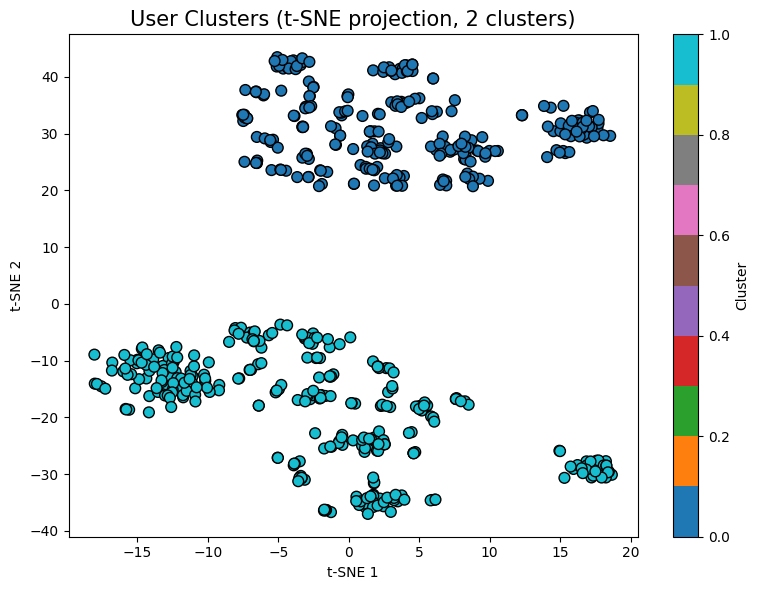

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# t-SNE works with similarities; precomputed metric expects a distance matrix
tsne = TSNE(n_components=best_n, metric='precomputed', random_state=42, init='random')
embeddings = tsne.fit_transform(combined_matrix)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings[:, 0], embeddings[:, 1],
    c=best_labels, cmap='tab10', s=60, edgecolor='k'
)
plt.title(f"User Clusters (t-SNE projection, {best_n} clusters)", fontsize=15)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()


In [ ]:
# import networkx as nx
# import numpy as np
# from scipy.spatial.distance import jensenshannon
# from itertools import combinations

# def compute_js_divergence(p_chain, q_chain, common_states):
#     """
#     Jensen–Shannon divergence on the subchain induced by common_states.
#     If no valid rows (all zeros), returns 1.0 (max divergence).
#     """
#     if not common_states:
#         return None

#     # Get indices of common states in each chain
#     p_indices = [p_chain.states.index(s) for s in common_states]
#     q_indices = [q_chain.states.index(s) for s in common_states]

#     # Extract the transition submatrices
#     P_sub = p_chain.p[np.ix_(p_indices, p_indices)]
#     Q_sub = q_chain.p[np.ix_(q_indices, q_indices)]

#     js_vals = []
#     for row_p, row_q in zip(P_sub, Q_sub):
#         # Only compute JS if both rows form valid distributions
#         if row_p.sum() > 0 and row_q.sum() > 0:
#             js_vals.append(jensenshannon(row_p, row_q, base=2))
#     return float(np.nanmean(js_vals)) if js_vals else 1.0

# def compute_penalty(p_chain, q_chain, common_states):
#     """
#     Simple structural penalty: fraction of non-overlapping states.
#     """
#     all_states = set(p_chain.states) | set(q_chain.states)
#     overlap = len(common_states)
#     return 1 - (overlap / len(all_states)) if all_states else 1.0

# def compute_shortest_path_sum(chain):
#     """
#     Sum of all-pairs shortest path lengths in the directed graph
#     induced by positive-probability transitions.
#     """
#     G = nx.DiGraph()
#     for i, src in enumerate(chain.states):
#         for j, dst in enumerate(chain.states):
#             if chain.p[i, j] > 0:
#                 G.add_edge(src, dst, weight=1)
#     lengths = dict(nx.all_pairs_shortest_path_length(G))
#     return sum(sum(d.values()) for d in lengths.values())

# def build_user_graph(user_chains, alpha=0.5, threshold=None):
#     """
#     Constructs an undirected graph where nodes are user_ids and
#     edge‐weights are distances as described.
#     """
#     G = nx.Graph()
#     # add users as nodes
#     for uid in user_chains:
#         G.add_node(uid)

#     # pairwise distances
#     for (u1, c1), (u2, c2) in combinations(user_chains.items(), 2):
#         common = set(c1.states) & set(c2.states)
#         if common:
#             js = compute_js_divergence(c1, c2, common)
#             pen = compute_penalty(c1, c2, common)
#             dist = alpha * js + (1 - alpha) * pen
#         else:
#             # no overlap → sum of each chain's path‐sum
#             dist = compute_shortest_path_sum(c1) + compute_shortest_path_sum(c2)

#         # optionally filter out very large distances
#         if threshold is None or dist <= threshold:
#             G.add_edge(u1, u2, weight=dist)

#     return G

# # --- Example usage ---------------------------------------------

# # Suppose user_chains is already populated:
# #   user_chains = {
# #       "alice": MarkovChain(...),
# #       "bob":   MarkovChain(...),
# #       ...
# #   }

# G = build_user_graph(user_chains, alpha=0.7, threshold=10.0)
# print("Number of connected components:", nx.number_connected_components(G))


/opt/homebrew/Caskroom/miniconda/base/envs/gogymi/lib/python3.12/site-packages/scipy/spatial/distance.py:1391: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/var/folders/tb/xz8bmvcs5mjgtg8nqczpcrcc0000gn/T/ipykernel_42196/3105069423.py:27: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(js_vals)) if js_vals else 1.0


KeyboardInterrupt: 

In [ ]:
# print(nx.connected_components(G))

NameError: name 'G' is not defined

# Clustering

In [74]:
zduration_sum.dtypes

user_id                      int64
course_id                    int64
activity_type               object
duration           timedelta64[ns]
mean_duration      timedelta64[ns]
std_duration       timedelta64[ns]
zscore_duration            float64
dtype: object

In [75]:
gap_days.dtypes

user_id      int64
gap_days    object
dtype: object

#### Compute distance matrices

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# import pandas as pd
# import numpy as np
# import networkx as nx
# from tslearn.metrics import dtw
# from scipy.spatial.distance import jensenshannon
# from sklearn.manifold import TSNE
# from sklearn.cluster import AgglomerativeClustering
# import matplotlib.pyplot as plt

# # 1. Prepare user list (already aligned)
# chains_users = set(user_chains.keys())

# # which users have gap_days?
# gap_users    = set(gap_days['user_id'])

# # which users have duration z‐scores?
# z_users      = set(zduration_sum['user_id'])

# # only keep those who have all three
# users_all = sorted(chains_users & gap_users & z_users)

# n_users = len(users_all)
# user_to_idx = {user: i for i, user in enumerate(users_all)}

# # 2. gap_days DTW Distance Matrix
# gap_days_map = gap_days.set_index('user_id')['gap_days'].to_dict()
# gap_days_seqs = [gap_days_map[u] for u in users_all]
# dtw_matrix = np.zeros((n_users, n_users))
# for i in range(n_users):
#     for j in range(i + 1, n_users):
#         d = dtw(gap_days_seqs[i], gap_days_seqs[j])
#         dtw_matrix[i, j] = dtw_matrix[j, i] = d

# # 3. user_chains Jensen-Shannon Distance
# user_stat_dists = [user_chains[u].steady_states[0] for u in users_all]
# jsd_matrix = np.zeros((n_users, n_users))
# for i in range(n_users):
#     for j in range(i + 1, n_users):
#         d = jensenshannon(user_stat_dists[i], user_stat_dists[j])
#         jsd_matrix[i, j] = jsd_matrix[j, i] = d

# # 4. zduration_sum Graph-based Distance
# B = nx.Graph()
# B.add_nodes_from(users_all, bipartite='user')
# activities = list(
#     set(tuple(x) for x in zduration_sum[['course_id', 'activity_type']].to_numpy())
# )
# B.add_nodes_from(activities, bipartite='activity')

# for row in zduration_sum.itertuples(index=False):
#     B.add_edge(row.user_id, (row.course_id, row.activity_type), weight=row.zscore_duration)

# graph_matrix = np.zeros((n_users, n_users))
# for i in range(n_users):
#     for j in range(i + 1, n_users):
#         u1, u2 = users_all[i], users_all[j]
#         u1_acts = set(B.neighbors(u1))
#         u2_acts = set(B.neighbors(u2))
#         common_acts = u1_acts & u2_acts
#         if common_acts:
#             z1 = [B.edges[u1, act]['weight'] for act in common_acts]
#             z2 = [B.edges[u2, act]['weight'] for act in common_acts]
#             dist = np.linalg.norm(np.array(z1) - np.array(z2))
#         else:
#             try:
#                 path = nx.shortest_path(B, u1, u2)
#                 edge_weights = []
#                 for k in range(0, len(path) - 2, 2):
#                     z1 = B.edges[path[k], path[k+1]]['weight']
#                     z2 = B.edges[path[k+2], path[k+1]]['weight']
#                     edge_weights.append(abs(z1 - z2))
#                 dist = sum(edge_weights)
#             except nx.NetworkXNoPath:
#                 dist = np.nan
#         graph_matrix[i, j] = graph_matrix[j, i] = dist

# max_g = np.nanmax(graph_matrix[~np.isnan(graph_matrix)])
# graph_matrix = np.nan_to_num(graph_matrix, nan=max_g * 1.1)

# # 5. Normalize and Combine
# def normalize_matrix(m):
#     flat = m[np.triu_indices_from(m, 1)]
#     m_norm = np.zeros_like(m)
#     if flat.max() > flat.min():
#         m_norm = (m - flat.min()) / (flat.max() - flat.min())
#     return m_norm

# dtw_norm = normalize_matrix(dtw_matrix)
# jsd_norm = normalize_matrix(jsd_matrix)
# graph_norm = normalize_matrix(graph_matrix)
# combined_matrix = (dtw_norm + jsd_norm + graph_norm) / 3.0

# # # 6. Cluster
# # n_clusters = 4  # You can change this number!
# # clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
# # labels = clustering.fit_predict(combined_matrix)

# # # 7. t-SNE visualization of user clusters
# # # t-SNE expects a similarity matrix, so we convert distance to similarity:
# # similarity = np.exp(-combined_matrix / combined_matrix.std())

# # tsne = TSNE(metric="precomputed", random_state=42)
# # embeddings = tsne.fit_transform(combined_matrix)

# # plt.figure(figsize=(8, 6))
# # scatter = plt.scatter(
# #     embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', s=60, edgecolor='k'
# # )
# # plt.title('User Clusters (t-SNE projection)', fontsize=16)
# # plt.xlabel('t-SNE 1')
# # plt.ylabel('t-SNE 2')
# # plt.colorbar(scatter, label='Cluster')
# # plt.tight_layout()
# # plt.show()

# # # Optional: dataframe of cluster assignments
# # cluster_df = pd.DataFrame({
# #     'user_id': users_all,
# #     'cluster': labels
# # })
# # display(cluster_df)


ValueError: operands could not be broadcast together with shapes (5,) (3,) 

### Cluster

Best number of clusters: 3 (silhouette score: 0.446)


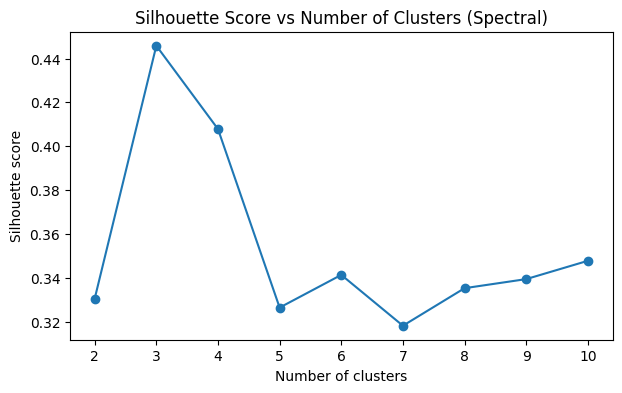

,user_id,cluster
0,1,1
1,4,1
2,6,1
3,7,1
4,9,1
...,...,...
600,4087,1
601,4089,2
602,4090,0
603,4092,1


In [ ]:
# from sklearn.cluster import SpectralClustering
# from sklearn.metrics import silhouette_score
# import numpy as np
# import matplotlib.pyplot as plt

# # Convert distance matrix to similarity (kernel trick: exp(-distance^2 / (2*sigma^2)))
# sigma = np.median(combined_matrix)
# similarity_matrix = np.exp(-combined_matrix ** 2 / (2.0 * sigma ** 2))

# range_n_clusters = range(2, min(11, len(users_all)))
# sil_scores = []
# best_score = -1
# best_n = None
# best_labels = None

# for n_clusters in range_n_clusters:
#     clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
#     labels = clustering.fit_predict(similarity_matrix)
#     # Silhouette expects a distance matrix, so use the original distance
#     score = silhouette_score(combined_matrix, labels, metric='precomputed')
#     sil_scores.append(score)
#     if score > best_score:
#         best_score = score
#         best_n = n_clusters
#         best_labels = labels

# print(f"Best number of clusters: {best_n} (silhouette score: {best_score:.3f})")
# plt.figure(figsize=(7, 4))
# plt.plot(list(range_n_clusters), sil_scores, marker='o')
# plt.title("Silhouette Score vs Number of Clusters (Spectral)")
# plt.xlabel("Number of clusters")
# plt.ylabel("Silhouette score")
# plt.show()

# cluster_df = pd.DataFrame({
#     'user_id': users_all,
#     'cluster': best_labels
# })
# display(cluster_df)


### Visualize best clustering

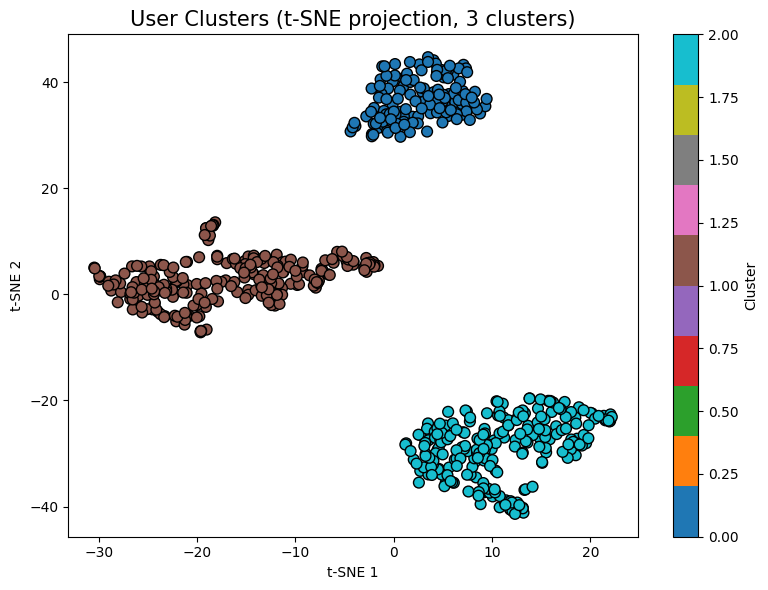

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# t-SNE works with similarities; precomputed metric expects a distance matrix
tsne = TSNE(n_components=2, metric='precomputed', random_state=42, init='random')
embeddings = tsne.fit_transform(combined_matrix)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings[:, 0], embeddings[:, 1],
    c=best_labels, cmap='tab10', s=60, edgecolor='k'
)
plt.title(f"User Clusters (t-SNE projection, {best_n} clusters)", fontsize=15)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()


## After clustering

In [47]:
cluster_users_dict = (
    cluster_df.groupby('cluster')['user_id']
    .apply(list)
    .to_dict()
)

# Now, cluster_users_dict[0] gives all user_ids in cluster 0, etc.


In [48]:
print("Number of users per cluster: " + 
      ", ".join(f"Cluster {i}: {len(cluster_users_dict[i])}" for i in range(best_n)))


Number of users per cluster: Cluster 0: 272, Cluster 1: 317


In [49]:
# average score per cluster

i=0
while i<best_n:
    print(f"Mean percentage for cluster {i} : {zscores[zscores['user_id'].isin(cluster_users_dict[i])].percentage.mean()}")
    print(f"Median percentage for cluster {i} : {zscores[zscores['user_id'].isin(cluster_users_dict[i])].percentage.median()}")

    i+=1
                                        

Mean percentage for cluster 0 : 52.3404542748984
Median percentage for cluster 0 : 59.0
Mean percentage for cluster 1 : 58.76557940032382
Median percentage for cluster 1 : 65.88235294117648


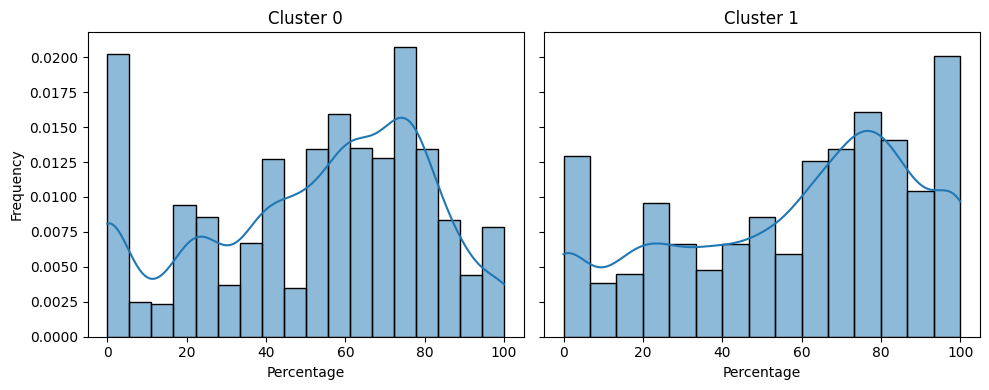

In [50]:
# Create subplots
fig, axes = plt.subplots(1, best_n, figsize=(5 * best_n, 4), sharey=True)

# If only one cluster, axes may not be a list
if best_n == 1:
    axes = [axes]

for i in range(best_n):
    ax = axes[i]
    cluster_users = cluster_users_dict[i]
    data = zscores[zscores['user_id'].isin(cluster_users)]
    
    sns.histplot(
        data=data, 
        x='percentage', 
        kde=True, 
        stat="density",  # Normalize heights to compare shapes
        ax=ax
    )
    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Percentage')
    ax.set_ylabel('Frequency' if i == 0 else '')  # Only leftmost plot shows Y-axis label

plt.tight_layout()
plt.show()

### Median course durations per cluster

Median durations per course and activity type for cluster 0 : 


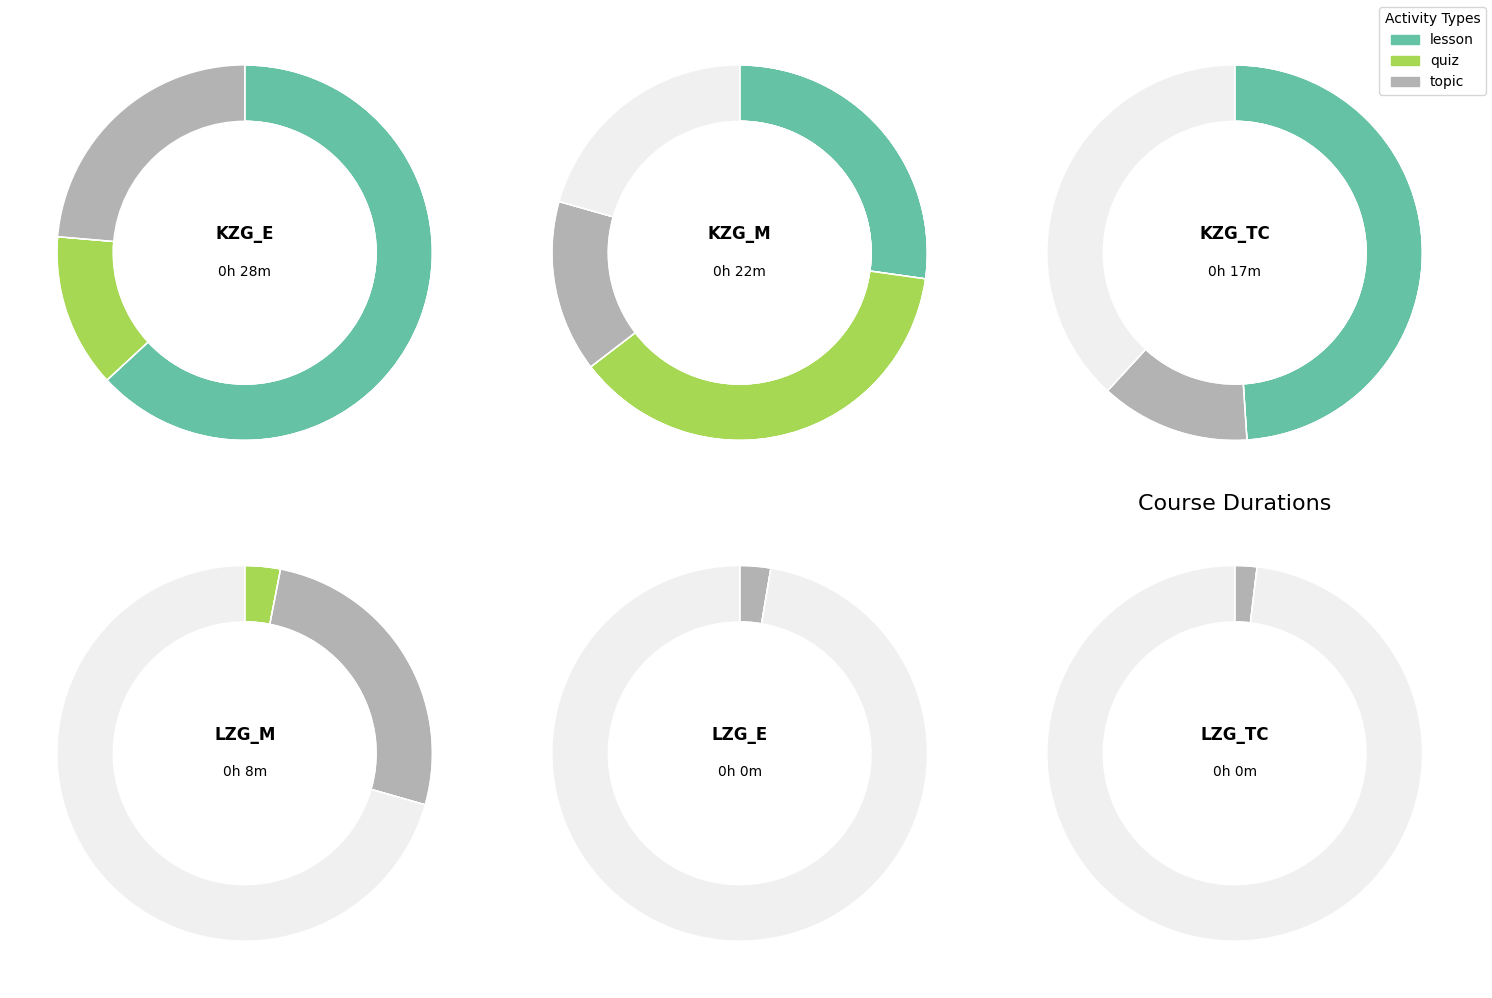

Median durations per course and activity type for cluster 1 : 


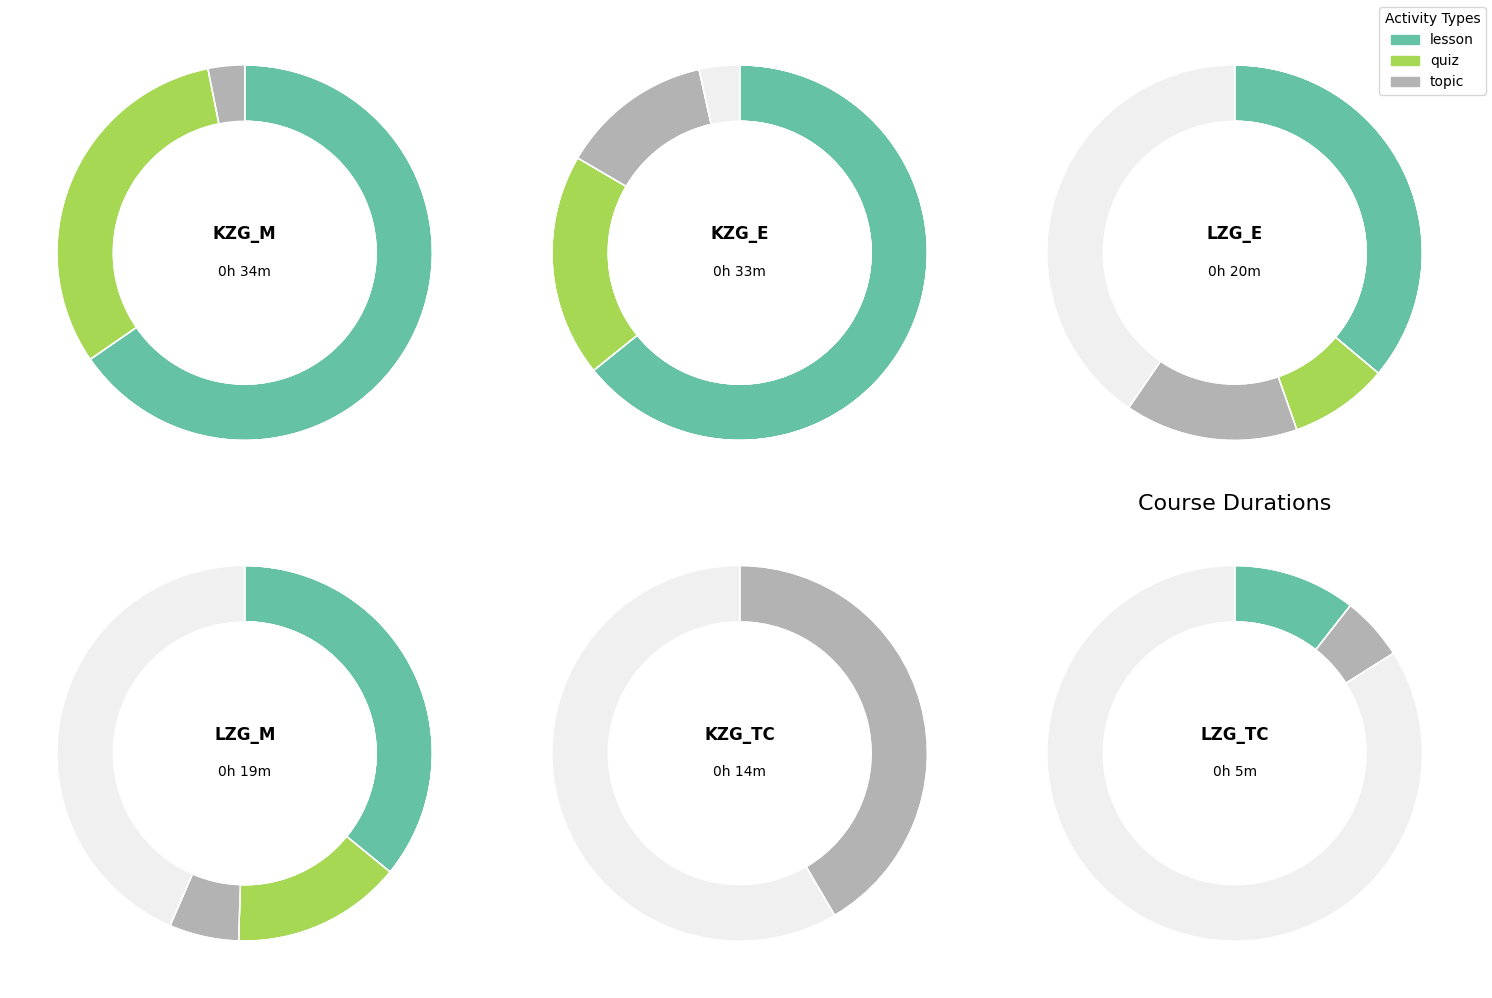

In [51]:
i=0
while i<best_n:
    print(f"Median durations per course and activity type for cluster {i} : ")
    plot_course_durations(
    activities_copy[activities_copy['user_id'].isin(cluster_users_dict[i])]
    .groupby(['course_id', 'activity_type'])['duration'].median().reset_index(),
    course_map_short
)
    i+=1



In [52]:
import numpy as np

# Get state order from any chain
states = user_chains[users_all[0]].states
n_states = len(states)

cluster_avg_matrices = {}

for cluster, user_ids in cluster_users_dict.items():
    matrices = []
    for uid in user_ids:
        tmatrix = np.array(user_chains[uid].p)
        matrices.append(tmatrix)
    if matrices:
        avg_matrix = np.mean(matrices, axis=0)
        cluster_avg_matrices[cluster] = avg_matrix

# Optional: Print or inspect
for cluster, mat in cluster_avg_matrices.items():
    print(f"\nCluster {cluster} average transition matrix:\n{mat}")


NameError: name 'users_all' is not defined

In [53]:
import ipywidgets as widgets
import networkx as nx
import plotly.graph_objs as go
from IPython.display import display
import numpy as np

def plot_avg_markov_with_edge_labels(cluster_id, avg_matrix, states):
    # Identify non-trivial states
    non_trivial_states = set()
    for i, state in enumerate(states):
        row = avg_matrix[i]
        col = avg_matrix[:, i]
        if not (np.isclose(row[i], 1.0) and np.isclose(row.sum(), 1.0) and np.isclose(col.sum(), 1.0)):
            non_trivial_states.add(state)

    # Build filtered graph
    G = nx.DiGraph()
    for i, from_state in enumerate(states):
        if from_state not in non_trivial_states:
            continue
        for j, to_state in enumerate(states):
            if to_state in non_trivial_states and avg_matrix[i, j] > 0:
                G.add_edge(from_state, to_state, weight=round(avg_matrix[i, j], 2))

    if len(G.nodes) == 0:
        print(f"No significant transitions to visualize for Cluster {cluster_id}.")
        return

    pos = nx.spring_layout(G, seed=42)

    edge_traces = []
    edge_annotations = []

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2]['weight']

        offset = 0.1 if G.has_edge(edge[1], edge[0]) and edge[0] != edge[1] else 0
        ctrl_x = (x0 + x1) / 2 + offset * (y1 - y0)
        ctrl_y = (y0 + y1) / 2 + offset * (x0 - x1)

        curve_x = [x0, ctrl_x, x1]
        curve_y = [y0, ctrl_y, y1]

        edge_traces.append(go.Scatter(
            x=curve_x, y=curve_y,
            line=dict(width=2, color='gray', shape='spline'),
            mode='lines',
            hoverinfo='none'
        ))

        edge_annotations.append(dict(
            x=ctrl_x, y=ctrl_y,
            xref='x', yref='y',
            text=f"{weight}",
            showarrow=False,
            font=dict(color='black', size=14),
            bgcolor='rgba(255, 255, 255, 0.7)',
            bordercolor='black',
            borderwidth=1,
            borderpad=2,
            align='center',
            opacity=0.9
        ))

        edge_annotations.append(dict(
            ax=ctrl_x, ay=ctrl_y,
            x=x1, y=y1,
            axref='x', ayref='y',
            xref='x', yref='y',
            showarrow=True,
            arrowhead=3,
            arrowsize=2,
            arrowwidth=2,
            arrowcolor='gray',
            opacity=0.8
        ))

    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        text=list(G.nodes()),
        mode='markers+text',
        textposition='middle center',
        marker=dict(size=60, color='lightblue', line=dict(width=3, color='darkblue'))
    )

    fig = go.Figure(data=edge_traces + [node_trace],
                    layout=go.Layout(
                        title=f"Cluster {cluster_id} Average Markov Model (Non-Trivial States)",
                        title_x=0.5,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(t=50, l=25, r=25, b=25),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        annotations=edge_annotations,
                        width=800,
                        height=600
                    ))
    fig.show()

# Widget for cluster selection
cluster_selector = widgets.Dropdown(
    options=sorted(cluster_avg_matrices.keys()),
    description='Cluster:',
    continuous_update=False
)

out = widgets.Output()
states = user_chains[users_all[0]].states  # Use state labels from any chain

def on_cluster_change(change):
    with out:
        out.clear_output(wait=True)
        cluster_id = change['new']
        avg_matrix = cluster_avg_matrices[cluster_id]
        plot_avg_markov_with_edge_labels(cluster_id, avg_matrix, states)

cluster_selector.observe(on_cluster_change, names='value')

display(cluster_selector, out)
cluster_selector.value = sorted(cluster_avg_matrices.keys())[0]  # Trigger first plot


NameError: name 'cluster_avg_matrices' is not defined

In [54]:
import numpy as np

prototype_users = {}
for cluster, user_ids in cluster_users_dict.items():
    avg_matrix = cluster_avg_matrices[cluster]
    min_dist = float('inf')
    best_uid = None
    for uid in user_ids:
        tmatrix = np.array(user_chains[uid].p)
        dist = np.linalg.norm(tmatrix - avg_matrix)
        if dist < min_dist:
            min_dist = dist
            best_uid = uid
    prototype_users[cluster] = best_uid

print("Prototype user per cluster:", prototype_users)

# Optional: visualize each prototype user
for cluster, uid in prototype_users.items():
    print(f"Cluster {cluster}: Prototype user {uid}")
    plot_user_markov_with_edge_labels(uid)


NameError: name 'cluster_avg_matrices' is not defined

In [55]:
import itertools

# Find the two most similar and most different users in the dataset
min_dist = float('inf')
max_dist = float('-inf')
most_similar_pair = None
most_different_pair = None

for i, j in itertools.combinations(range(len(users_all)), 2):
    dist = combined_matrix[i, j]
    if dist < min_dist:
        min_dist = dist
        most_similar_pair = (users_all[i], users_all[j])
    if dist > max_dist:
        max_dist = dist
        most_different_pair = (users_all[i], users_all[j])

print(f"Most similar pair: {most_similar_pair}, distance={min_dist:.3f}")
print(f"Most different pair: {most_different_pair}, distance={max_dist:.3f}")

# Visualize their Markov chains (or other features)
for uid in most_similar_pair + most_different_pair:
    plot_user_markov_with_edge_labels(uid)


NameError: name 'users_all' is not defined

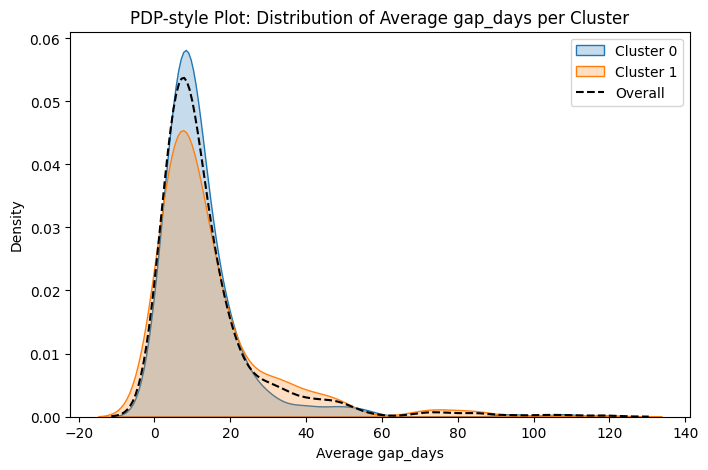

In [56]:
import matplotlib.pyplot as plt

# Calculate average gap_days per user
gap_days_avg = gap_days.set_index('user_id')['gap_days'].apply(np.mean)

plt.figure(figsize=(8, 5))
for cluster in sorted(cluster_users_dict.keys()):
    user_ids = cluster_users_dict[cluster]
    vals = gap_days_avg[user_ids]
    sns.kdeplot(vals, label=f'Cluster {cluster}', fill=True)
sns.kdeplot(gap_days_avg, color='k', linestyle='--', label='Overall', fill=False)
plt.xlabel("Average gap_days")
plt.ylabel("Density")
plt.title("PDP-style Plot: Distribution of Average gap_days per Cluster")
plt.legend()
plt.show()


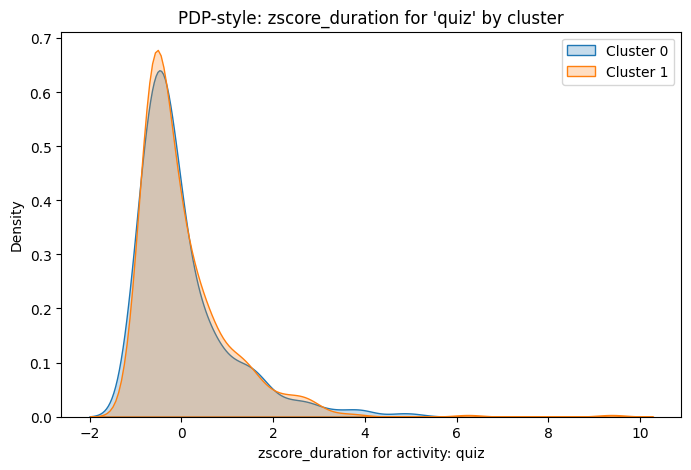

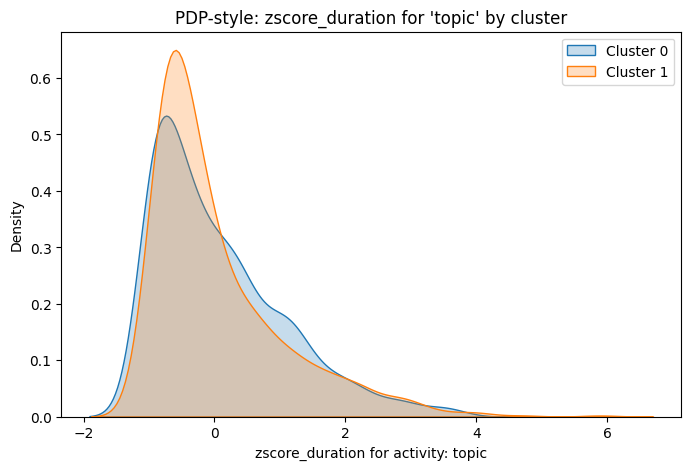

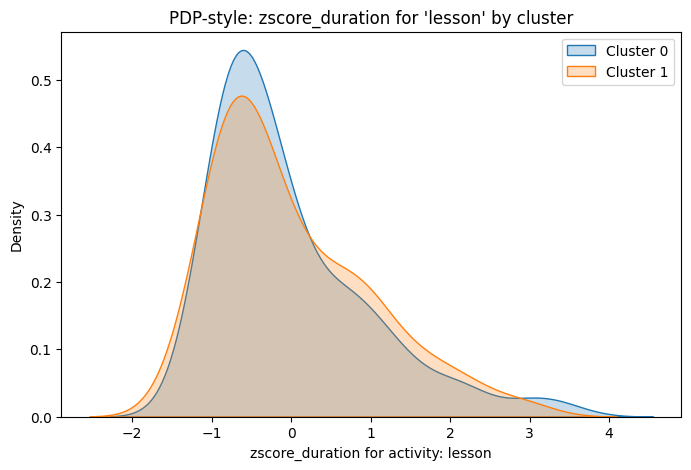

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose an activity_type to investigate, e.g. 'video'
activity_types = zduration_sum['activity_type'].unique()

for activity in activity_types:
    plt.figure(figsize=(8, 5))
    for cluster, user_ids in cluster_users_dict.items():
        vals = zduration_sum[
            (zduration_sum['user_id'].isin(user_ids)) & 
            (zduration_sum['activity_type'] == activity)
        ]['zscore_duration']
        if len(vals) > 0:
            sns.kdeplot(vals, label=f'Cluster {cluster}', fill=True)
    plt.xlabel(f"zscore_duration for activity: {activity}")
    plt.ylabel("Density")
    plt.title(f"PDP-style: zscore_duration for '{activity}' by cluster")
    plt.legend()
    plt.show()


In [58]:
from scipy.stats import entropy
import numpy as np

def mc_entropy(mc):
    tmatrix = np.array(mc.p)
    # Row-wise entropy (one per state), average over all
    return np.mean([entropy(row) for row in tmatrix if np.sum(row) > 0])

entropy_per_user = {uid: mc_entropy(user_chains[uid]) for uid in users_all}

plt.figure(figsize=(8, 5))
for cluster, user_ids in cluster_users_dict.items():
    vals = [entropy_per_user[uid] for uid in user_ids]
    sns.kdeplot(vals, label=f'Cluster {cluster}', fill=True)
plt.xlabel("Average Markov Chain Entropy")
plt.ylabel("Density")
plt.title("PDP-style: Markov Chain Entropy per Cluster")
plt.legend()
plt.show()


NameError: name 'users_all' is not defined

In [59]:
# Compute features
gap_avg = gap_days.set_index('user_id')['gap_days'].apply(np.mean)
zscore_avg = zduration_sum.groupby('user_id')['zscore_duration'].mean()

# Prepare DataFrame
pdp_df = pd.DataFrame({
    'user_id': users_all,
    'gap_days_avg': [gap_avg[u] for u in users_all],
    'zscore_duration_avg': [zscore_avg[u] for u in users_all],
    'cluster': [cluster_df.set_index('user_id').loc[u, 'cluster'] for u in users_all]
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pdp_df, x='gap_days_avg', y='zscore_duration_avg',
    hue='cluster', palette='tab10'
)
plt.xlabel("Average gap_days")
plt.ylabel("Average zscore_duration")
plt.title("Joint PDP: gap_days vs zscore_duration by Cluster")
plt.legend()
plt.show()


NameError: name 'users_all' is not defined

/var/folders/tb/xz8bmvcs5mjgtg8nqczpcrcc0000gn/T/ipykernel_6391/1923112592.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


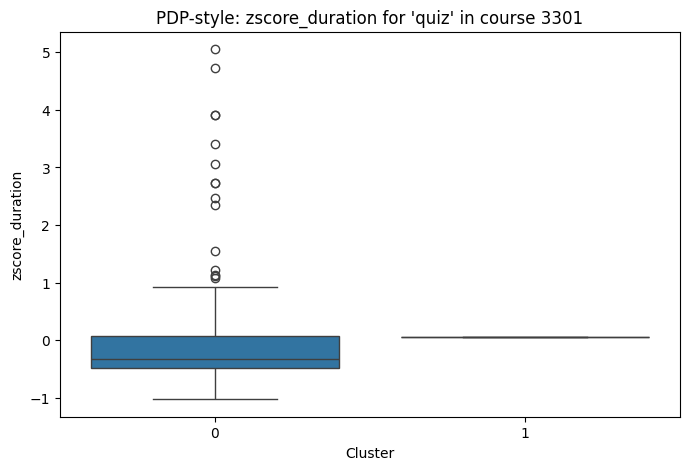

In [60]:
course_id = zduration_sum['course_id'].unique()[0]  # pick a course_id, or loop
activity_type = 'quiz'  # or any activity_type

plt.figure(figsize=(8, 5))
data = []
for cluster, user_ids in cluster_users_dict.items():
    vals = zduration_sum[
        (zduration_sum['user_id'].isin(user_ids)) &
        (zduration_sum['activity_type'] == activity_type) &
        (zduration_sum['course_id'] == course_id)
    ]['zscore_duration']
    for v in vals:
        data.append({'cluster': cluster, 'zscore_duration': v})

sns.boxplot(
    data=pd.DataFrame(data),
    x='cluster', y='zscore_duration', palette='tab10'
)
plt.title(f"PDP-style: zscore_duration for '{activity_type}' in course {course_id}")
plt.xlabel("Cluster")
plt.ylabel("zscore_duration")
plt.show()


/var/folders/tb/xz8bmvcs5mjgtg8nqczpcrcc0000gn/T/ipykernel_6391/545095377.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


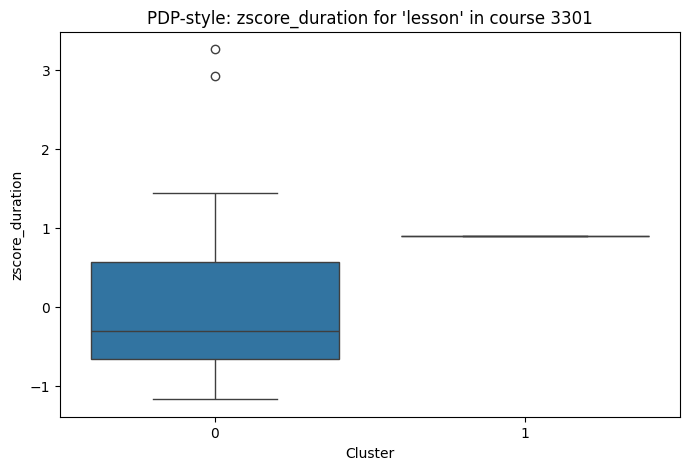

In [61]:
course_id = zduration_sum['course_id'].unique()[0]  # pick a course_id, or loop
activity_type = 'lesson'  # or any activity_type

plt.figure(figsize=(8, 5))
data = []
for cluster, user_ids in cluster_users_dict.items():
    vals = zduration_sum[
        (zduration_sum['user_id'].isin(user_ids)) &
        (zduration_sum['activity_type'] == activity_type) &
        (zduration_sum['course_id'] == course_id)
    ]['zscore_duration']
    for v in vals:
        data.append({'cluster': cluster, 'zscore_duration': v})

sns.boxplot(
    data=pd.DataFrame(data),
    x='cluster', y='zscore_duration', palette='tab10'
)
plt.title(f"PDP-style: zscore_duration for '{activity_type}' in course {course_id}")
plt.xlabel("Cluster")
plt.ylabel("zscore_duration")
plt.show()


/var/folders/tb/xz8bmvcs5mjgtg8nqczpcrcc0000gn/T/ipykernel_6391/3320967520.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


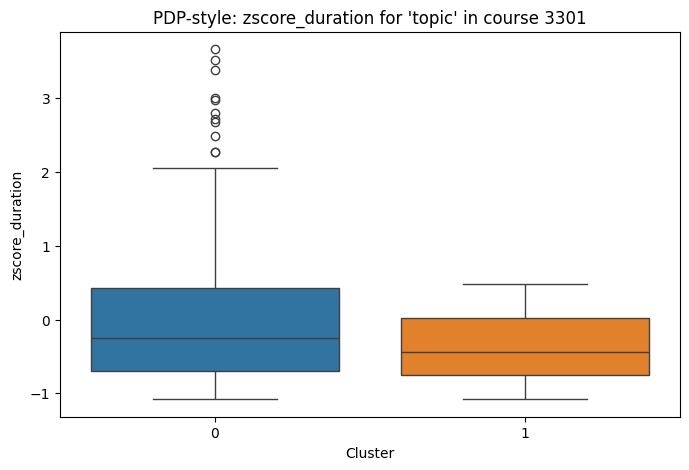

In [62]:
course_id = zduration_sum['course_id'].unique()[0]  # pick a course_id, or loop
activity_type = 'topic'  # or any activity_type

plt.figure(figsize=(8, 5))
data = []
for cluster, user_ids in cluster_users_dict.items():
    vals = zduration_sum[
        (zduration_sum['user_id'].isin(user_ids)) &
        (zduration_sum['activity_type'] == activity_type) &
        (zduration_sum['course_id'] == course_id)
    ]['zscore_duration']
    for v in vals:
        data.append({'cluster': cluster, 'zscore_duration': v})

sns.boxplot(
    data=pd.DataFrame(data),
    x='cluster', y='zscore_duration', palette='tab10'
)
plt.title(f"PDP-style: zscore_duration for '{activity_type}' in course {course_id}")
plt.xlabel("Cluster")
plt.ylabel("zscore_duration")
plt.show()


In [63]:
# For each cluster, find the most probable transition in avg Markov
for cluster, avg_matrix in cluster_avg_matrices.items():
    max_idx = np.unravel_index(np.argmax(avg_matrix), avg_matrix.shape)
    from_state, to_state = states[max_idx[0]], states[max_idx[1]]
    prob = avg_matrix[max_idx]
    print(f"Cluster {cluster}: Most probable transition: {from_state} → {to_state} (p={prob:.2f})")


NameError: name 'cluster_avg_matrices' is not defined

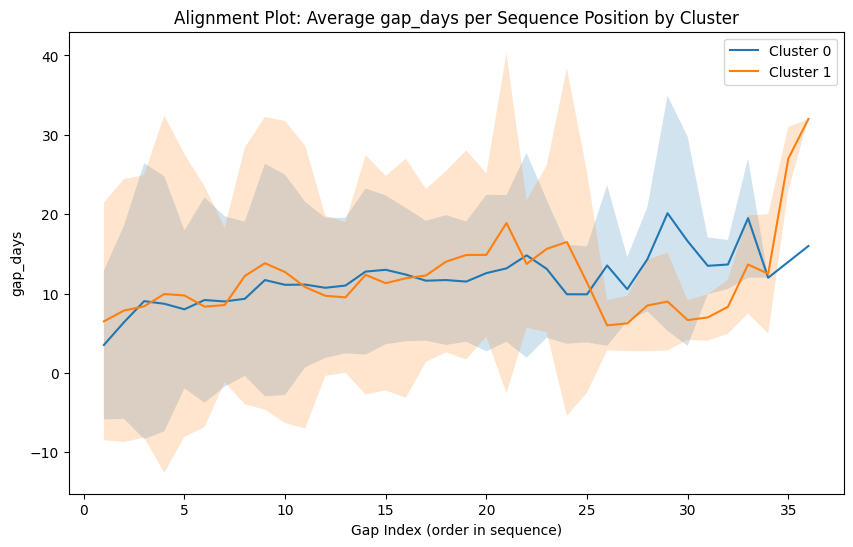

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

max_len = max(len(seq) for seq in gap_days['gap_days'])
gap_days_map = gap_days.set_index('user_id')['gap_days'].to_dict()

plt.figure(figsize=(10, 6))
for cluster, user_ids in cluster_users_dict.items():
    aligned = []
    for uid in user_ids:
        seq = gap_days_map[uid]
        padded = np.full(max_len, np.nan)
        padded[:len(seq)] = seq
        aligned.append(padded)
    aligned = np.vstack(aligned)
    mean_per_pos = np.nanmean(aligned, axis=0)
    std_per_pos = np.nanstd(aligned, axis=0)
    plt.plot(range(1, max_len + 1), mean_per_pos, label=f'Cluster {cluster}')
    plt.fill_between(range(1, max_len + 1), mean_per_pos - std_per_pos, mean_per_pos + std_per_pos, alpha=0.2)

plt.xlabel('Gap Index (order in sequence)')
plt.ylabel('gap_days')
plt.title('Alignment Plot: Average gap_days per Sequence Position by Cluster')
plt.legend()
plt.show()


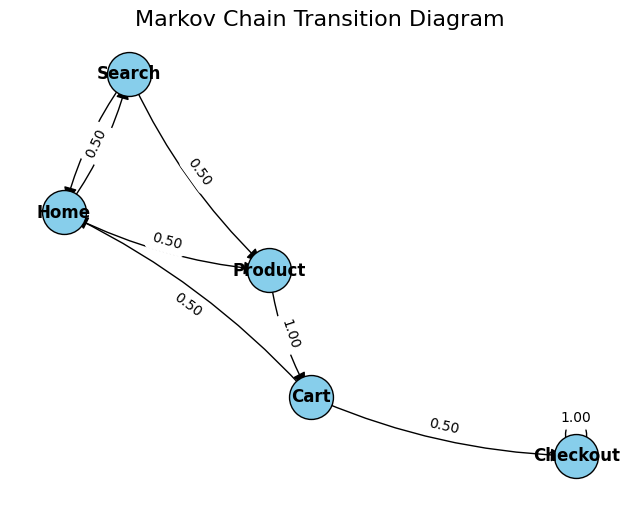

interactive(children=(Dropdown(description='user', options=('Alice', 'Bob', 'Charlie'), value='Alice'), Output…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pydtmc as dtmc
from ipywidgets import interact
import plotly.graph_objects as go

# --- Sample User Data ---
users_sequences = {
    "Alice": ["Home", "Search", "Product", "Cart", "Checkout"],
    "Bob": ["Home", "Search", "Home", "Product"],
    "Charlie": ["Home", "Product", "Cart", "Home"],
}

# --- Create Transition Matrix ---
all_states = sorted({state for seq in users_sequences.values() for state in seq})
state_idx = {state: i for i, state in enumerate(all_states)}

transition_counts = np.zeros((len(all_states), len(all_states)))
for seq in users_sequences.values():
    for from_state, to_state in zip(seq[:-1], seq[1:]):
        transition_counts[state_idx[from_state], state_idx[to_state]] += 1

transition_matrix = np.zeros_like(transition_counts)
for i in range(len(all_states)):
    row_sum = transition_counts[i].sum()
    if row_sum == 0:
        transition_matrix[i, i] = 1.0
    else:
        transition_matrix[i] = transition_counts[i] / row_sum
transition_matrix = np.round(transition_matrix, 10)

# --- Create Markov Chain object for calculations (if needed) ---
chain = dtmc.MarkovChain(transition_matrix, all_states)

# --- Build the NetworkX Graph Manually ---
def plot_markov_chain_networkx(transition_matrix, state_names):
    G = nx.DiGraph()
    for i, from_state in enumerate(state_names):
        for j, to_state in enumerate(state_names):
            prob = transition_matrix[i, j]
            if prob > 0:
                G.add_edge(from_state, to_state, weight=prob)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue', edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=20, connectionstyle='arc3,rad=0.1')
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title("Markov Chain Transition Diagram", fontsize=16)
    plt.axis('off')
    plt.show()

plot_markov_chain_networkx(transition_matrix, all_states)

# --- Animate User Sequences with Plotly ---
def animate_user_sequence(user):
    seq = users_sequences[user]
    frames = []
    for i in range(1, len(seq) + 1):
        current_seq = seq[:i]
        x = list(range(len(current_seq)))
        frames.append(go.Frame(
            data=[go.Scatter(
                x=x, 
                y=current_seq, 
                mode="lines+markers", 
                marker=dict(size=14), 
                line=dict(width=4)
            )],
            name=f"Step {i}"
        ))

    fig = go.Figure(
        data=[go.Scatter(
            x=[0], 
            y=[seq[0]], 
            mode="lines+markers", 
            marker=dict(size=14), 
            line=dict(width=4)
        )],
        layout=go.Layout(
            title=f"Action Sequence for {user}",
            xaxis=dict(title="Step", tickmode='linear'),
            yaxis=dict(title="State"),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(
                        label="Play",
                        method="animate",
                        args=[None, {"frame": {"duration": 1000, "redraw": True}, "fromcurrent": True}]
                    ),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "fromcurrent": True}]
                    )
                ]
            )]
        ),
        frames=frames
    )

    fig.update_layout(width=800, height=500)
    fig.show()

# --- Interactive Dropdown ---
interact(animate_user_sequence, user=list(users_sequences.keys()));


In [186]:
# Example: Build a mapping for a given user
def get_state_labels(user_id):
    user_states_df = final_transitions[final_transitions['user_id'] == user_id]
    # Assume you have a column with the state index in the Markov chain (e.g., 'state_index')
    # If not, we match order with Markov chain's states!
    if 'state_index' in user_states_df.columns:
        idx_to_label = user_states_df.set_index('state_index')['activity_state'].to_dict()
        return [idx_to_label[i] for i in sorted(idx_to_label.keys())]
    else:
        # fallback: Markov chain states in order correspond to unique activity_state in user_states_df
        ordered_labels = user_states_df.drop_duplicates('activity_state')['activity_state'].tolist()
        return ordered_labels


In [187]:
import ipywidgets as widgets
import networkx as nx
import plotly.graph_objs as go
from IPython.display import display
import numpy as np

def plot_user_markov_final_transitions(user_id):
    mc = user_chains[user_id]
    matrix = np.array(mc.p)
    # Get labels for each state from final_transitions
    node_labels = get_state_labels(user_id)
    assert len(node_labels) == len(mc.states), "Label/state mismatch!"

    # Build graph (show transitions with prob > 0.01)
    G = nx.DiGraph()
    for i, from_state in enumerate(node_labels):
        for j, to_state in enumerate(node_labels):
            prob = matrix[i, j]
            if prob > 0.01:
                G.add_edge(from_state, to_state, weight=round(prob, 2))

    if len(G.nodes) == 0:
        print(f"No significant transitions to visualize for User {user_id}.")
        return

    pos = nx.spring_layout(G, seed=42)

    edge_traces = []
    edge_annotations = []
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2]['weight']
        offset = 0.13 if G.has_edge(edge[1], edge[0]) and edge[0] != edge[1] else 0
        ctrl_x = (x0 + x1) / 2 + offset * (y1 - y0)
        ctrl_y = (y0 + y1) / 2 + offset * (x0 - x1)
        curve_x = [x0, ctrl_x, x1]
        curve_y = [y0, ctrl_y, y1]
        edge_traces.append(go.Scatter(
            x=curve_x, y=curve_y,
            line=dict(width=2, color='gray', shape='spline'),
            mode='lines',
            hoverinfo='none'
        ))
        edge_annotations.append(dict(
            x=ctrl_x, y=ctrl_y,
            xref='x', yref='y',
            text=f"{weight}",
            showarrow=False,
            font=dict(color='black', size=13),
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='black',
            borderwidth=1,
            borderpad=1,
            align='center',
            opacity=0.9
        ))
        edge_annotations.append(dict(
            ax=ctrl_x, ay=ctrl_y,
            x=x1, y=y1,
            axref='x', ayref='y',
            xref='x', yref='y',
            showarrow=True,
            arrowhead=3,
            arrowsize=2,
            arrowwidth=2,
            arrowcolor='gray',
            opacity=0.75
        ))

    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        text=list(G.nodes()),
        mode='markers+text',
        textposition='middle center',
        marker=dict(size=70, color='lightpink', line=dict(width=4, color='darkred'))
    )

    fig = go.Figure(data=edge_traces + [node_trace],
                    layout=go.Layout(
                        title=f"User {user_id}: Markov Chain (Final Transitions)",
                        title_x=0.5,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(t=55, l=25, r=25, b=25),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        annotations=edge_annotations,
                        width=900,
                        height=700
                    ))
    fig.show()


In [188]:
user_selector = widgets.Dropdown(
    options=sorted(user_chains.keys()),
    description='User ID:',
    continuous_update=False
)
out = widgets.Output()

def on_user_change(change):
    with out:
        out.clear_output(wait=True)
        plot_user_markov_final_transitions(change['new'])

user_selector.observe(on_user_change, names='value')

display(user_selector, out)
user_selector.value = sorted(user_chains.keys())[0]


Dropdown(description='User ID:', options=(1, 4, 6, 7, 9, 10, 11, 16, 17, 19, 20, 22, 23, 26, 38, 48, 49, 50, 5…

Output()

In [189]:
final_transitions.dtypes

user_id            int64
activity_state    object
state_idx          int64
next_state_idx     int64
dtype: object

In [190]:
user_chains[1].states

['quiz_KZG_E', 'topic_KZG_TC', 'topic_KZG_E', 'topic_KZG_M', 'quiz_KZG_M']

In [ ]:
import ipywidgets as widgets
import networkx as nx
import plotly.graph_objs as go
from IPython.display import display
import numpy as np

def plot_user_markovchain(user_id):
    mc = user_chains[user_id]
    matrix = np.array(mc.p)
    node_labels = mc.states  # Already activity_type_courseShortName

    G = nx.DiGraph()
    for i, from_state in enumerate(node_labels):
        for j, to_state in enumerate(node_labels):
            prob = matrix[i, j]
            if prob > 0.01:
                G.add_edge(from_state, to_state, weight=round(prob, 2))

    if len(G.nodes) == 0:
        print(f"No significant transitions to visualize for User {user_id}.")
        return

    pos = nx.spring_layout(G, seed=42)
    edge_traces = []
    edge_annotations = []

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2]['weight']
        offset = 0.13 if G.has_edge(edge[1], edge[0]) and edge[0] != edge[1] else 0
        ctrl_x = (x0 + x1) / 2 + offset * (y1 - y0)
        ctrl_y = (y0 + y1) / 2 + offset * (x0 - x1)
        curve_x = [x0, ctrl_x, x1]
        curve_y = [y0, ctrl_y, y1]
        edge_traces.append(go.Scatter(
            x=curve_x, y=curve_y,
            line=dict(width=2, color='gray', shape='spline'),
            mode='lines',
            hoverinfo='none'
        ))
        edge_annotations.append(dict(
            x=ctrl_x, y=ctrl_y,
            xref='x', yref='y',
            text=f"{weight}",
            showarrow=False,
            font=dict(color='black', size=13),
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='black',
            borderwidth=1,
            borderpad=1,
            align='center',
            opacity=0.9
        ))
        edge_annotations.append(dict(
            ax=ctrl_x, ay=ctrl_y,
            x=x1, y=y1,
            axref='x', ayref='y',
            xref='x', yref='y',
            showarrow=True,
            arrowhead=3,
            arrowsize=2,
            arrowwidth=2,
            arrowcolor='gray',
            opacity=0.75
        ))

    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        text=list(G.nodes()),
        mode='markers+text',
        textposition='middle center',
        marker=dict(size=70, color='lightpink', line=dict(width=4, color='darkred'))
    )

    fig = go.Figure(data=edge_traces + [node_trace],
                    layout=go.Layout(
                        title=f"User {user_id}: Markov Chain",
                        title_x=0.5,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(t=55, l=25, r=25, b=25),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        annotations=edge_annotations,
                        width=900,
                        height=700
                    ))
    fig.show()

# Interactive dropdown
user_selector = widgets.Dropdown(
    options=sorted(user_chains.keys()),
    description='User ID:',
    continuous_update=False
)
out = widgets.Output()

def on_user_change(change):
    with out:
        out.clear_output(wait=True)
        plot_user_markovchain(change['new'])

user_selector.observe(on_user_change, names='value')

display(user_selector, out)
user_selector.value = sorted(user_chains.keys())[0]


Dropdown(description='User ID:', options=(1, 4, 6, 7, 9, 10, 11, 16, 17, 19, 20, 22, 23, 26, 38, 48, 49, 50, 5…

Output()